# **Radiomics Feature Extraction, Aggregation, and Data Preparation**

This workflow provides a detailed approach for radiomic analysis of patient data, including data loading, preprocessing, feature extraction, and preparation for machine learning models. It systematically organizes the different stages involved in working with medical imaging data to predict PD-L1 expression levels. Each section is designed to cover specific aspects of the workflow, from importing necessary libraries to preparing a balanced and well-structured dataset for further analysis.

### Sections Overview:

1. **Library Imports**:  
   Import necessary libraries for data manipulation, image processing, feature extraction, and visualization.

2. **Data Loading and Preprocessing**:  
   Define helper functions for loading, processing, and segmenting DICOM images. This includes methods for image normalization, resizing, and saving/loading intermediate results.

3. **Feature Extraction and Handling**:  
   Perform feature extraction using radiomic techniques and handle features through flattening, aggregation, and selection.

4. **Data Preparation for Analysis**:  
   Prepare feature data, handle missing values, and balance classes using techniques such as SMOTE to ensure a robust dataset for machine learning.

5. **Saving and Reloading Processed Data**:  
   Save intermediate results, extracted features, and structured datasets to facilitate reproducibility and efficient reuse of data in future analyses.

## Importing Libraries for Data Manipulation, Image Processing, and Machine Learning

The following libraries are essential for different aspects of this project, including handling DICOM images, extracting radiomic features, training machine learning models, and visualizing results.


In [ ]:
# Operating system library for file and directory manipulation
import os
from collections import OrderedDict

# Numerical computation and array manipulation
import numpy as np

# Data manipulation and analysis library
import pandas as pd

# Visualization library for creating plots and charts
import matplotlib.pyplot as plt

# Library for reading and processing DICOM files (medical images)
import pydicom

# SimpleITK for image segmentation and processing
import SimpleITK as sitk

# skimage for image filtering, transformations, and resizing
from skimage import filters
from skimage.transform import resize

# Radiomics feature extraction library
from radiomics import featureextractor

# Scikit-learn modules for model development and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, log_loss)

# Machine learning classifiers: Random Forest and XGBoost
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Elastic Net regression for feature selection
from sklearn.linear_model import ElasticNetCV

# Statistical methods for random sampling
from scipy.stats import randint

# SMOTE for handling imbalanced datasets
from imblearn.over_sampling import SMOTE

# TensorFlow library for building deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

## Data Loading and Preprocessing Functions

This section defines helper functions for loading and processing DICOM images. It includes methods for loading patient slices, preprocessing images, and saving/loading processed slices for future use.


In [ ]:
def load_processed_patients(log_file):
    """
    Load the set of processed patients from the log file.

    Args:
        log_file (str): Path to the log file storing processed patient IDs.

    Returns:
        set: A set containing patient IDs that have been processed.
    """
    if os.path.exists(log_file):
        with open(log_file, 'r') as file:
            # Read all processed patient IDs and store them in a set
            processed_patients = set(file.read().splitlines())
    else:
        # If log file does not exist, return an empty set
        processed_patients = set()
    return processed_patients

def save_processed_patient(patient_id, log_file):
    """
    Append a processed patient ID to the log file.

    Args:
        patient_id (str): ID of the patient to be saved in the log.
        log_file (str): Path to the log file.
    """
    with open(log_file, 'a') as file:
        # Write the patient ID into the log file
        file.write(f"{patient_id}\n")


### Loading and Saving Patient Slices

The following functions handle the loading of patient slices from DICOM images, resizing them to a standard shape, and saving the processed slices for future use. This approach helps to streamline the data loading and preprocessing workflow.


In [ ]:
def load_full_body_slices(directory, target_shape=(512, 512)):
    """
    Load and resize all DICOM slices for a single patient to a target shape.

    Args:
        directory (str): Directory containing DICOM files for the patient.
        target_shape (tuple): The desired shape for each image slice, typically (512, 512).

    Returns:
        np.ndarray: A 3D array containing resized slices for the patient.
    """
    slices = []  # Initialize an empty list to hold image slices
    files = [os.path.join(directory, f) for f in sorted(os.listdir(directory)) if f.endswith('.dcm')]

    for file in files:
        try:
            # Read the DICOM file
            ds = pydicom.dcmread(file)
            # Resize each slice to the target shape for uniformity
            resized_slice = resize(ds.pixel_array, target_shape, anti_aliasing=True)
            slices.append(resized_slice)
        except Exception as e:
            # Print the error if the DICOM file cannot be read
            print(f"Error reading {file}: {e}")
    return np.stack(slices) if slices else np.array([])  # Return the slices as a numpy array or an empty array if no slices


def load_lung_segmented_slices(directory, target_shape=(512, 512), slice_range=(120, 260)):
    """
    Load and resize specified DICOM slices for a single patient within a given slice range.

    Args:
        directory (str): Directory containing DICOM files for the patient.
        target_shape (tuple): The desired shape for each image slice.
        slice_range (tuple): The range of slice numbers to include.

    Returns:
        np.ndarray: A 3D array containing resized slices for the patient.
    """
    slices = []
    files = [os.path.join(directory, f) for f in sorted(os.listdir(directory)) if f.endswith('.dcm')]

    for file in files:
        # Extract the numerical part of the filename (assumes the format is 'IM<number>.dcm')
        file_name = os.path.basename(file)
        slice_number = int(''.join(filter(str.isdigit, file_name)))

        # Skip slices outside the specified range
        if slice_number < slice_range[0] or slice_number > slice_range[1]:
            continue

        try:
            ds = pydicom.dcmread(file)
            # Resize each slice to the target shape
            resized_slice = resize(ds.pixel_array, target_shape, anti_aliasing=True)
            slices.append(resized_slice)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    return np.stack(slices) if slices else np.array([])


def load_patient_slices(directory, target_shape=(512, 512), data_type='full_body', slice_range=None):
    """
    Load and resize DICOM slices for a single patient based on data type.

    Args:
        directory (str): Directory containing DICOM files for the patient.
        target_shape (tuple): The desired shape for each image slice.
        data_type (str): Type of data to load ('full_body' or 'lung_segmented').
        slice_range (tuple): The range of slice numbers to load (only applicable for lung-segmented data).

    Returns:
        np.ndarray: A 3D array containing the resized slices for the patient.
    """
    if data_type == 'full_body':
        # Call function to load full-body data
        return load_full_body_slices(directory, target_shape=target_shape)
    elif data_type == 'lung_segmented':
        if slice_range is None:
            raise ValueError("slice_range must be provided for lung-segmented data.")
        # Call function to load lung-segmented data with slice range
        return load_lung_segmented_slices(directory, target_shape=target_shape, slice_range=slice_range)
    else:
        raise ValueError(f"Invalid data_type: {data_type}. Must be 'full_body' or 'lung_segmented'.")

In [ ]:
def load_and_save_patient_slices(directory, output_dir):
    """
    Load all DICOM slices for a single patient, resize, and save them to disk.

    Args:
        directory (str): Directory containing DICOM files for the patient.
        output_dir (str): Directory where the processed slices will be saved.

    Returns:
        np.ndarray: A 3D array containing resized slices for the patient.
    """
    slices = load_patient_slices(directory)  # Load and resize slices
    patient_id = os.path.basename(directory)  # Extract patient ID from directory name
    save_path = os.path.join(output_dir, f'{patient_id}_slices.npy')  # Define save path for the slices
    np.save(save_path, slices)  # Save the slices as a numpy file
    return slices

def load_saved_slices(patient_id, output_dir):
    """
    Load previously saved slices from disk.

    Args:
        patient_id (str): ID of the patient whose slices are to be loaded.
        output_dir (str): Directory where the saved slices are located.

    Returns:
        np.ndarray or None: A 3D array containing saved slices if they exist, otherwise None.
    """
    load_path = os.path.join(output_dir, f'{patient_id}_slices.npy')  # Construct the file path
    if os.path.exists(load_path):  # Check if the file exists
        return np.load(load_path, allow_pickle=True)  # Load and return the saved slices
    return None  # Return None if the file does not exist


## Image Preprocessing and Segmentation

The functions below handle image preprocessing using normalization and smoothing filters. Subsequently, lung segmentation is applied using a thresholding approach to isolate lung regions from the full-body images.


In [ ]:
def preprocess_image(image):
    """
    Preprocess the image for segmentation: normalize and apply filters.

    Args:
        image (np.ndarray): Input image slice to be preprocessed.

    Returns:
        np.ndarray: Preprocessed image with normalized pixel values and smoothed using a Gaussian filter.
    """
    if image.size == 0:
        return np.array([])

    # Normalize the image pixel values to the range [0, 1]
    image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    # Apply Gaussian smoothing to reduce noise
    image_smoothed = filters.gaussian(image_normalized, sigma=1)
    return image_smoothed

def preprocess_and_save_slices(slices, output_dir, patient_id):
    """
    Preprocess each slice and save the result to disk.

    Args:
        slices (np.ndarray): A 3D array containing image slices for a patient.
        output_dir (str): Directory where the preprocessed slices will be saved.
        patient_id (str): ID of the patient for naming the save file.

    Returns:
        np.ndarray: A list of preprocessed slices.
    """
    # Apply preprocessing to each slice
    preprocessed_slices = [preprocess_image(slice) for slice in slices]
    save_path = os.path.join(output_dir, f'{patient_id}_preprocessed.npy')  # Save path for preprocessed slices
    np.save(save_path, preprocessed_slices)  # Save the preprocessed slices to disk
    return preprocessed_slices


## Lung Segmentation

The following functions handle lung segmentation by applying a thresholding method to each preprocessed slice. This step isolates the lung regions, which is critical for feature extraction and analysis.


In [ ]:
def segment_lungs(image):
    """
    Segment lungs using a simple thresholding approach.

    Args:
        image (np.ndarray): Preprocessed image slice to be segmented.

    Returns:
        np.ndarray: Binary image where the lung regions are segmented out using a threshold.
    """
    if image.size == 0:
        return np.array([])  # Return empty array if image is empty

    # Apply Otsu's thresholding method to separate lung regions from the background
    thresh = filters.threshold_otsu(image)
    binary_image = image > thresh
    return binary_image  # Return the segmented binary image

def segment_and_save_slices(preprocessed_slices, output_dir, patient_id):
    """
    Segment lung regions for each preprocessed slice and save the result to disk.

    Args:
        preprocessed_slices (list of np.ndarray): List of preprocessed image slices.
        output_dir (str): Directory where the segmented slices will be saved.
        patient_id (str): ID of the patient for naming the save file.

    Returns:
        list: List of segmented slices (binary images).
    """
    # Apply lung segmentation to each preprocessed slice
    segmented_slices = [segment_lungs(slice) for slice in preprocessed_slices]
    save_path = os.path.join(output_dir, f'{patient_id}_segmented.npy')  # Define save path for segmented slices
    np.save(save_path, segmented_slices)  # Save the segmented slices to disk
    return segmented_slices


## Radiomic Feature Extraction

Radiomic features are extracted from the segmented lung slices using PyRadiomics. These features provide quantitative information about the texture, shape, and intensity of the segmented regions, which are used as input to machine learning models.


In [ ]:
def extract_features(segmented_slices):
    """
    Extract radiomic features from segmented slices using PyRadiomics.

    Args:
        segmented_slices (list of np.ndarray): List of segmented lung slices for a patient.

    Returns:
        list: A list of dictionaries, each containing radiomic features for a single slice.
    """
    features = []  # Initialize an empty list to store features
    extractor = featureextractor.RadiomicsFeatureExtractor()  # Initialize the feature extractor

    for i, slice in enumerate(segmented_slices):
        if slice.size == 0:
            continue  # Skip if the slice is empty

        # Convert the slice and its binary mask to SimpleITK images
        mask = sitk.GetImageFromArray(slice.astype(np.uint8))
        image = sitk.GetImageFromArray(slice.astype(np.float32))

        # Extract radiomic features using the PyRadiomics library
        result = extractor.execute(image, mask)
        features.append(result)  # Append the result to the features list
    return features  # Return the extracted features

def extract_and_save_features(segmented_slices, output_dir, patient_id):
    """
    Extract features and save the result to disk.

    Args:
        segmented_slices (list of np.ndarray): List of segmented slices.
        output_dir (str): Directory where the extracted features will be saved.
        patient_id (str): ID of the patient for naming the save file.

    Returns:
        list: List of extracted features for the patient.
    """
    features = extract_features(segmented_slices)  # Extract features from segmented slices
    save_path = os.path.join(output_dir, f'{patient_id}_features.npy')  # Define save path for features
    np.save(save_path, features)  # Save the features to disk
    return features


## Incremental Data Processing

The `process_directory_incremental` function processes all patients in a given directory with an incremental approach. This function checks if a patient has already been processed, loads or processes slices as needed, and applies preprocessing, segmentation, and feature extraction.


In [ ]:
def process_directory_incremental(base_dir, output_dir, log_file, target_shape=(512, 512), slice_range=None, data_type='full_body'):
    """
    Process all patients in a given directory with incremental processing.

    Parameters:
    - base_dir (str): Base directory containing subdirectories of patients.
    - output_dir (str): Directory to save the processed slices, preprocessed images, and features.
    - log_file (str): Log file to track processed patients.
    - target_shape (tuple): Tuple specifying the target shape for resizing slices (default is (512, 512)).
    - slice_range (tuple): Range of slice numbers to load for lung-segmented data (default is None for full body).
    - data_type (str): Type of segmentation data to load ('full_body' or 'lung_segmented').

    Returns:
    - results (dict): Dictionary containing the extracted features for each processed patient.
    """
    # Load the set of already processed patients from the log file
    processed_patients = load_processed_patients(log_file)
    results = {}

    # Iterate over each patient's directory in the base directory
    for patient_dir in sorted(os.listdir(base_dir)):
        if patient_dir in processed_patients:
            print(f"Skipping {patient_dir} (already processed)...")
            continue

        # Define the full path to the patient directory
        patient_path = os.path.join(base_dir, patient_dir)
        if os.path.isdir(patient_path):
            print(f"Processing {patient_dir} ({data_type} data)...")

            # Load or process slices using the appropriate function for the specified data type
            slices = load_and_save_patient_slices(
                directory=patient_path,
                output_dir=output_dir,
                target_shape=target_shape,
                data_type=data_type,
                slice_range=slice_range  # Only applicable for lung-segmented data
            )

            # Continue preprocessing and feature extraction if slices were successfully loaded
            if slices.size > 0:
                # Preprocess the slices
                preprocessed_slices = preprocess_and_save_slices(slices, output_dir, patient_id=patient_dir)

                # Segment the slices based on the type of data
                segmented_slices = segment_and_save_slices(preprocessed_slices, output_dir, patient_id=patient_dir)

                # Extract features
                features = extract_and_save_features(segmented_slices, output_dir, patient_id=patient_dir)

                # Store the results in the dictionary
                results[patient_dir] = features

                # Mark the patient as processed in the log file
                save_processed_patient(patient_dir, log_file)

    return results


## Feature Labeling for Classification

After extracting features for each patient, this section labels the features based on whether the patient is positive or negative. Positive cases are labeled as `1`, and negative cases as `0`.


In [ ]:
def label_features(all_features, positive_dir, negative_dir):
    """
    Label the features as positive (1) or negative (0).

    Args:
        all_features (dict): Dictionary with patient IDs as keys and extracted features as values.
        positive_dir (str): Directory containing IDs of positive patients.
        negative_dir (str): Directory containing IDs of negative patients.

    Returns:
        tuple: Arrays `X` (features) and `y` (labels) for all patients.
    """
    X = []  # Feature vectors
    y = []  # Labels

    # Label positive cases (1)
    for patient_id in os.listdir(positive_dir):
        if patient_id in all_features:
            X.extend(all_features[patient_id])
            y.extend([1] * len(all_features[patient_id]))  # Label as 1 (positive)

    # Label negative cases (0)
    for patient_id in os.listdir(negative_dir):
        if patient_id in all_features:
            X.extend(all_features[patient_id])
            y.extend([0] * len(all_features[patient_id]))  # Label as 0 (negative)

    return np.array(X), np.array(y)  # Convert to numpy arrays and return


## Model Training and Evaluation

The `train_model` function trains a specified machine learning classifier using labeled features and evaluates its performance using metrics like accuracy, ROC-AUC, including the classification report. The results are visualized using plots from log loss and confusion matrix for easier interpretation.


In [ ]:
def train_model(X_train, X_test, y_train, y_test, clf):
    """
    Train and evaluate a machine learning model.

    Args:
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.
        clf (sklearn estimator): The classifier to be trained and evaluated.

    Returns:
        clf: The trained classifier.
    """
    # Train the classifier using the training data
    clf.fit(X_train, y_train)

    # Make predictions on the testing data
    predictions = clf.predict(X_test)

    # Calculate accuracy and ROC-AUC score
    accuracy = accuracy_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    # Print performance metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    print(classification_report(y_test, predictions))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate and plot Log Loss for each prediction
    probabilities = clf.predict_proba(X_test)[:, 1]
    epsilon = 1e-15  # Small constant to avoid log(0)
    log_loss_scores = [-np.log(max(min(prob, 1 - epsilon), epsilon)) if label == 1 else -np.log(max(min(1 - prob, 1 - epsilon), epsilon)) for prob, label in zip(probabilities, y_test)]

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(log_loss_scores)), log_loss_scores, 'r')
    plt.xlabel('Sample Index')
    plt.ylabel('Log Loss')
    plt.title('Log Loss for Each Prediction')
    plt.show()

    return clf


## Setting Up Paths and Directory Structure

This section defines the paths to the directories containing the positive and negative patient data, as well as the output directory for saving processed results for the full body scans. The paths are crucial for ensuring that the data is correctly loaded and saved during the incremental processing workflow.


In [ ]:
# Define paths to directories containing patient data
base_directory = 'C:\\Anonymized PD-L1'  # Path to the base directory where patient data is stored
positive_dir = os.path.join(base_directory, 'PD-L1 Positive')  # Subdirectory for PD-L1 positive patients
negative_dir = os.path.join(base_directory, 'PD-L1 Negative')  # Subdirectory for PD-L1 negative patients

# Directory where intermediate results will be saved, this includes extracted features
output_directory = 'C:\\Anonymized PD-L1 Output'

# Log file to keep track of processed patients
log_file = 'processed_patients.log'  # This file records IDs of patients that have already been processed

In [ ]:
# Process the positive patient directory and extract features for full body images
positive_data_full_body = process_directory_incremental(
    base_dir=positive_dir,
    output_dir=output_directory,
    log_file=log_file,
    target_shape=(512, 512),  # Resize to 512x512
    data_type='full_body'  # Specify that the data is full-body
)

# Process the negative patient directory and extract features
negative_data_full_body = process_directory_incremental(
    base_dir=negative_dir,
    output_dir=output_directory,
    log_file=log_file,
    target_shape=(512, 512),  # Resize to 512x512
    data_type='full_body'  # Specify that the data is full-body
)

Skipping Patient 1 (already processed)...
Skipping Patient 10 (already processed)...
Skipping Patient 100 (already processed)...
Skipping Patient 101 (already processed)...
Skipping Patient 102 (already processed)...
Skipping Patient 103 (already processed)...
Skipping Patient 104 (already processed)...
Skipping Patient 105 (already processed)...
Skipping Patient 106 (already processed)...
Skipping Patient 107 (already processed)...
Skipping Patient 108 (already processed)...
Skipping Patient 109 (already processed)...
Skipping Patient 11 (already processed)...
Skipping Patient 110 (already processed)...
Skipping Patient 111 (already processed)...
Skipping Patient 112 (already processed)...
Skipping Patient 113 (already processed)...
Skipping Patient 114 (already processed)...
Skipping Patient 115 (already processed)...
Skipping Patient 116 (already processed)...
Skipping Patient 117 (already processed)...
Skipping Patient 118 (already processed)...
Skipping Patient 119 (already proces

## Loading Features from the Output Directory

The `load_features_from_output_dir` function loads extracted features for each patient from the output directory. It iterates through the base directory, checks if the features file exists for each patient, and loads the features if available. This step is essential when you want to quickly access previously extracted features without re-processing the DICOM images.


In [ ]:
def load_features_from_output_dir(base_dir, output_dir):
    """
    Load all features from the output directory for patients in a given base directory.

    This function scans through the base directory, finds each patient's feature file in the output directory,
    and loads the features into a dictionary.

    Args:
        base_dir (str): Directory containing patient subdirectories (PD-L1 Positive or Negative).
        output_dir (str): Directory where the extracted feature files are stored.

    Returns:
        dict: A dictionary where keys are patient IDs and values are their respective features.
    """
    features_data = {}  # Initialize an empty dictionary to hold the features

    # Iterate through all patient subdirectories in the base directory
    for patient_dir in sorted(os.listdir(base_dir)):
        patient_path = os.path.join(base_dir, patient_dir)  # Get the full path of the patient directory

        if os.path.isdir(patient_path):  # Check if the path is a directory
            patient_id = os.path.basename(patient_dir)  # Extract the patient ID from the directory name
            feature_file = os.path.join(output_dir, f'{patient_id}_features.npy')  # Construct path to the feature file

            if os.path.exists(feature_file):  # Check if the feature file exists
                print(f"Loading features for {patient_id} from {feature_file}")
                features = np.load(feature_file, allow_pickle=True)  # Load the feature file

                if features is not None:  # Check if the features were loaded successfully
                    features_data[patient_id] = features  # Store the features in the dictionary
                    print(f"Loaded {len(features)} features for {patient_id}")
            else:
                print(f"No feature file found for {patient_id} at {feature_file}")

    return features_data  # Return the dictionary containing all loaded features


## Loading Features for Positive and Negative Patient Directories

The previously defined function is used to load features for patients in the positive and negative directories separately. This avoids the need to extract features again if they have already been saved to disk.


In [ ]:
# Define paths to directories containing patient data
base_directory = 'C:\\Anonymized PD-L1'  # Path to the base directory where patient data is stored
positive_dir = os.path.join(base_directory, 'PD-L1 Positive')  # Subdirectory for PD-L1 positive patients
negative_dir = os.path.join(base_directory, 'PD-L1 Negative')  # Subdirectory for PD-L1 negative patients

# Directory where intermediate results will be saved, this includes extracted features
output_directory = 'C:\\Anonymized PD-L1 Output'

# Log file to keep track of processed patients
log_file = 'processed_patients.log'  # This file records IDs of patients that have already been processed

In [ ]:
# Load features for positive and negative directories
positive_data = load_features_from_output_dir(positive_dir, output_directory)
negative_data = load_features_from_output_dir(negative_dir, output_directory)

print(f"Number of patients loaded in positive_data: {len(positive_data)}")
print(f"Number of patients loaded in negative_data: {len(negative_data)}")

Loading features for Patient 1 from C:\Anonymized PD-L1 Output\Patient 1_features.npy
Loaded 399 features for Patient 1
Loading features for Patient 10 from C:\Anonymized PD-L1 Output\Patient 10_features.npy
Loaded 472 features for Patient 10
Loading features for Patient 100 from C:\Anonymized PD-L1 Output\Patient 100_features.npy
Loaded 415 features for Patient 100
Loading features for Patient 101 from C:\Anonymized PD-L1 Output\Patient 101_features.npy
Loaded 425 features for Patient 101
Loading features for Patient 102 from C:\Anonymized PD-L1 Output\Patient 102_features.npy
Loaded 403 features for Patient 102
Loading features for Patient 103 from C:\Anonymized PD-L1 Output\Patient 103_features.npy
Loaded 478 features for Patient 103
Loading features for Patient 104 from C:\Anonymized PD-L1 Output\Patient 104_features.npy
Loaded 433 features for Patient 104
Loading features for Patient 105 from C:\Anonymized PD-L1 Output\Patient 105_features.npy
Loaded 452 features for Patient 105
L

## Load and Label Features

In this step, the previously extracted radiomic features was loaded for both positive and negative patients from the output directory. The features are then combined and labeled appropriately, where positive cases are labeled as `1` and negative cases as `0`. This step prepares the feature matrix and label array for subsequent machine learning model training and evaluation.


In [ ]:
# Load extracted features for PD-L1 positive patients
positive_data = load_features_from_output_dir(positive_dir, output_directory)

# Load extracted features for PD-L1 negative patients
negative_data = load_features_from_output_dir(negative_dir, output_directory)

# Combine positive and negative features, and assign labels
# `features` is the feature matrix, and `labels` is the corresponding label array.
features, labels = label_features({**positive_data, **negative_data}, positive_dir, negative_dir)

Loading features for Patient 1 from C:\Anonymized PD-L1 Output\Patient 1_features.npy
Loaded 399 features for Patient 1
Loading features for Patient 10 from C:\Anonymized PD-L1 Output\Patient 10_features.npy
Loaded 472 features for Patient 10
Loading features for Patient 100 from C:\Anonymized PD-L1 Output\Patient 100_features.npy
Loaded 415 features for Patient 100
Loading features for Patient 101 from C:\Anonymized PD-L1 Output\Patient 101_features.npy
Loaded 425 features for Patient 101
Loading features for Patient 102 from C:\Anonymized PD-L1 Output\Patient 102_features.npy
Loaded 403 features for Patient 102
Loading features for Patient 103 from C:\Anonymized PD-L1 Output\Patient 103_features.npy
Loaded 478 features for Patient 103
Loading features for Patient 104 from C:\Anonymized PD-L1 Output\Patient 104_features.npy
Loaded 433 features for Patient 104
Loading features for Patient 105 from C:\Anonymized PD-L1 Output\Patient 105_features.npy
Loaded 452 features for Patient 105
L

## Feature Preparation, Selection, and Handling Class Imbalance

This section covers the complete feature preparation and selection process, starting from flattening the `OrderedDict` structure to handling class imbalance in the dataset using SMOTE. Each step ensures that the features are well-prepared for building robust machine learning models.

### Step 1: Flatten the OrderedDicts and Convert to a DataFrame
- The extracted features are initially stored as nested `OrderedDict` structures. This step involves flattening these dictionaries and converting them into a tabular format using a pandas DataFrame. The resulting DataFrame makes it easier to handle the data and perform subsequent processing tasks.

### Step 2: Handle Missing Values
- Missing values in the feature matrix can negatively impact model performance. Therefore, any missing values are replaced with `0` to ensure a complete dataset with no gaps.

### Step 3: Scale the Features
- Standard scaling is applied to ensure all features have a mean of `0` and a standard deviation of `1`. This step is crucial for models like Elastic Net, which are sensitive to the scale of the input features.

### Step 4: Apply Elastic Net with Cross-Validation
- Elastic Net, a regularized linear model that combines Lasso and Ridge regression, is applied with cross-validation. This model helps identify the most important features by balancing L1 (Lasso) and L2 (Ridge) penalties and setting unimportant feature coefficients to zero.

### Step 5: Get the Coefficients of the Best Model
- After fitting the Elastic Net model, the coefficients of the best model are retrieved. These coefficients indicate the importance of each feature, with non-zero coefficients representing selected features.

### Step 6: Select Features with Non-Zero Coefficients
- Features with non-zero coefficients are considered important and are selected for further analysis or model building. The indices and names of these features are extracted and displayed.

### Step 7: Creating a DataFrame with Selected Features
- After feature selection, a new DataFrame is created containing only the selected features. This step reduces the dimensionality of the data, making it easier to analyze and build models with only the most relevant features.

### Step 8: Combining Features and Labels, Saving, and Reloading Data
- The selected features are combined with their corresponding labels, saved to a CSV file, and re-loaded for subsequent use. This step helps organize the data in a structured format, making it easier to share, save, and reload at any point in the analysis pipeline.

### Step 9: Data Splitting, Class Imbalance Handling, and Visualization
- The combined features and labels are split into training and testing sets using a 70-30 split. The class distribution in the training set is analyzed to identify any imbalance.
- **SMOTE (Synthetic Minority Over-sampling Technique)** is applied to the training data to create a balanced class distribution. This helps improve model performance and reduces bias towards the majority class.
- The class distribution is visualized before and after applying SMOTE to verify that the data has been balanced correctly.


### Step 1: Flatten the OrderedDicts and Convert to a DataFrame

The features extracted for each patient are stored in a series of nested `OrderedDicts`. To facilitate further processing, these dictionaries are flatten into a tabular format and convert them into a pandas DataFrame. Non-numeric values are skipped during the conversion.


In [ ]:
# Initialize an empty list to hold the flattened feature dictionaries
flattened_features = []

# Iterate through each feature set and flatten the nested dictionaries
for feature_set in features:
    flat_dict = {}  # Create an empty dictionary to hold flattened features
    for key, value in feature_set.items():
        try:
            # Convert feature values to float, if possible
            flat_dict[key] = float(value)
        except (ValueError, TypeError):
            continue  # Skip non-numeric values (strings or None)

    # Append the flattened dictionary to the list
    flattened_features.append(flat_dict)

# Convert the list of flattened dictionaries to a DataFrame
features_df = pd.DataFrame(flattened_features)

# Display the total number of features (columns) in the DataFrame before feature selection
print(f"Total number of features before selection: {features_df.shape[1]}")

Total number of features before selection: 98


### Step 2: Handle Missing Values

Missing values can affect the performance of machine learning models. In this step, any missing values in the DataFrame are filled with `0` to ensure a complete dataset.

In [ ]:
# Fill any missing values in the feature DataFrame with 0
features_df.fillna(0, inplace=True)

### Step 3: Scale the Features

Feature scaling is performed using `StandardScaler` to ensure that all features are on a similar scale. This helps improve the performance of models, especially those that are sensitive to the scale of features, such as Elastic Net.


In [ ]:
# Initialize a StandardScaler to standardize the feature values
scaler = StandardScaler()

# Fit the scaler to the features and transform the feature matrix
features_scaled = scaler.fit_transform(features_df)

### Step 4: Apply Elastic Net with Cross-Validation

An `ElasticNetCV` model is used to perform feature selection with cross-validation. The model searches for the best combination of `l1_ratio` and `alpha` to identify important features that have a non-zero coefficient.


In [ ]:
# Initialize an ElasticNetCV model with cross-validation
elastic_net_cv = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],  # List of l1_ratios to try
    alphas=[0.1, 1.0, 10.0],  # List of alpha values (regularization strengths) to try
    cv=5,  # 5-fold cross-validation
    max_iter=10000  # Increase the maximum number of iterations for convergence
)

# Fit the ElasticNetCV model to the scaled feature matrix and labels
elastic_net_cv.fit(features_scaled, labels)

ElasticNetCV(alphas=[0.1, 1.0, 10.0], cv=5,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=10000)

### Step 5: Get the Coefficients of the Best Model

After fitting the Elastic Net model, the coefficients of the best model are retrieved. These coefficients indicate the importance of each feature, where non-zero values represent selected features.


In [ ]:
# Retrieve the coefficients of the best Elastic Net model
coefficients = elastic_net_cv.coef_

### Step 6: Select Features with Non-Zero Coefficients

Features with non-zero coefficients are considered important and are selected for further analysis or model building. The indices and names of these features are extracted and displayed.


In [ ]:
# Select the indices of features with non-zero coefficients
selected_features = np.where(coefficients != 0)[0]

# Retrieve the names of the selected features from the DataFrame columns
selected_feature_names = features_df.columns[selected_features]

# Output the selected features
print(f"Number of selected features: {len(selected_features)}")
print(f"Selected feature indices: {selected_features}")
print(f"Selected feature names: {list(selected_feature_names)}")

Number of selected features: 27
Selected feature indices: [ 0  3  4  7 20 47 48 49 50 51 61 65 66 67 69 70 71 74 75 76 77 87 88 89
 90 91 92]
Selected feature names: ['diagnostics_Image-original_Mean', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'original_firstorder_Energy', 'original_firstorder_TotalEnergy', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_RunEntropy', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUnifor

### Step 7: Creating a DataFrame with Selected Features

After feature selection using Elastic Net, a new DataFrame is created containing only the selected features. This step helps reduce the dimensionality of the data and focuses the analysis on features deemed important by the model. The resulting DataFrame is used for subsequent machine learning tasks, as it contains only the most relevant features.

By using the `info()` method, we can verify the structure of the new DataFrame and ensure that only the selected features have been retained.


In [ ]:
# Create a new DataFrame containing only the selected features
selected_features_df = features_df[selected_feature_names]

# Display the structure and details of the new DataFrame
selected_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134590 entries, 0 to 134589
Data columns (total 27 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   diagnostics_Image-original_Mean                  134590 non-null  float64
 1   diagnostics_Mask-original_VoxelNum               134590 non-null  float64
 2   diagnostics_Mask-original_VolumeNum              134590 non-null  float64
 3   original_firstorder_Energy                       134590 non-null  float64
 4   original_firstorder_TotalEnergy                  134590 non-null  float64
 5   original_gldm_DependenceEntropy                  134590 non-null  float64
 6   original_gldm_DependenceNonUniformity            134590 non-null  float64
 7   original_gldm_DependenceNonUniformityNormalized  134590 non-null  float64
 8   original_gldm_DependenceVariance                 134590 non-null  float64
 9   original_gldm_G

### Step 8: Combining Features and Labels, Saving, and Reloading Data

In this step, the features and labels are combined into a single DataFrame, saved to a CSV file, and re-loaded for subsequent use. This helps organize the data in a structured format, making it easier to share, save, and reload at any point in the analysis pipeline.

The combined DataFrame contains all the selected radiomic features along with their corresponding labels. After saving the combined data, it is re-loaded to verify the structure and ensure that the data has been correctly saved and re-loaded without loss of information.

In [ ]:
# Create a DataFrame from the labels array
labels_df = pd.DataFrame(labels, columns=['label'])

# Combine the features and labels into a single DataFrame along the columns
combined_df = pd.concat([selected_features_df, labels_df], axis=1)

# Save the combined DataFrame to a CSV file for future use
combined_df.to_csv('full_radiomics_features_labels.csv', index=False)

In [ ]:
# Display the structure and information of the combined DataFrame
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134590 entries, 0 to 134589
Data columns (total 28 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   diagnostics_Image-original_Mean                  134590 non-null  float64
 1   diagnostics_Mask-original_VoxelNum               134590 non-null  float64
 2   diagnostics_Mask-original_VolumeNum              134590 non-null  float64
 3   original_firstorder_Energy                       134590 non-null  float64
 4   original_firstorder_TotalEnergy                  134590 non-null  float64
 5   original_gldm_DependenceEntropy                  134590 non-null  float64
 6   original_gldm_DependenceNonUniformity            134590 non-null  float64
 7   original_gldm_DependenceNonUniformityNormalized  134590 non-null  float64
 8   original_gldm_DependenceVariance                 134590 non-null  float64
 9   original_gldm_G

In [ ]:
# Re-load the combined features and labels from the CSV file
combined_df = pd.read_csv('full_radiomics_features_labels.csv')

# Display the structure and information of the re-loaded DataFrame
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134590 entries, 0 to 134589
Data columns (total 28 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   diagnostics_Image-original_Mean                  134590 non-null  float64
 1   diagnostics_Mask-original_VoxelNum               134590 non-null  float64
 2   diagnostics_Mask-original_VolumeNum              134590 non-null  float64
 3   original_firstorder_Energy                       134590 non-null  float64
 4   original_firstorder_TotalEnergy                  134590 non-null  float64
 5   original_gldm_DependenceEntropy                  134590 non-null  float64
 6   original_gldm_DependenceNonUniformity            134590 non-null  float64
 7   original_gldm_DependenceNonUniformityNormalized  134590 non-null  float64
 8   original_gldm_DependenceVariance                 134590 non-null  float64
 9   original_gldm_G

In [ ]:
# Separate the features and labels from the re-loaded combined DataFrame
features_df = combined_df.drop('label', axis=1)  # Drop the 'label' column to create the features DataFrame
labels = combined_df['label']  # Extract the 'label' column as the labels array

In [ ]:
# Display the structure and information of the features DataFrame
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134590 entries, 0 to 134589
Data columns (total 27 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   diagnostics_Image-original_Mean                  134590 non-null  float64
 1   diagnostics_Mask-original_VoxelNum               134590 non-null  float64
 2   diagnostics_Mask-original_VolumeNum              134590 non-null  float64
 3   original_firstorder_Energy                       134590 non-null  float64
 4   original_firstorder_TotalEnergy                  134590 non-null  float64
 5   original_gldm_DependenceEntropy                  134590 non-null  float64
 6   original_gldm_DependenceNonUniformity            134590 non-null  float64
 7   original_gldm_DependenceNonUniformityNormalized  134590 non-null  float64
 8   original_gldm_DependenceVariance                 134590 non-null  float64
 9   original_gldm_G

### Step 9: Data Splitting, Class Imbalance Handling, and Visualization

In this step, the combined features and labels are split into training and test sets. The class distribution in the training set is analyzed and visualized to identify any imbalance between positive and negative cases.

**SMOTE (Synthetic Minority Over-sampling Technique)** is applied to the training data to balance the class distribution. This is crucial in cases where one class significantly outnumbers the other, as it helps improve the model's performance and reduces bias towards the majority class. The class distribution is visualized again after applying SMOTE to verify that the data has been balanced correctly.


Class distribution in y_train before SMOTE:
label
1    62847
0    31366
Name: count, dtype: int64


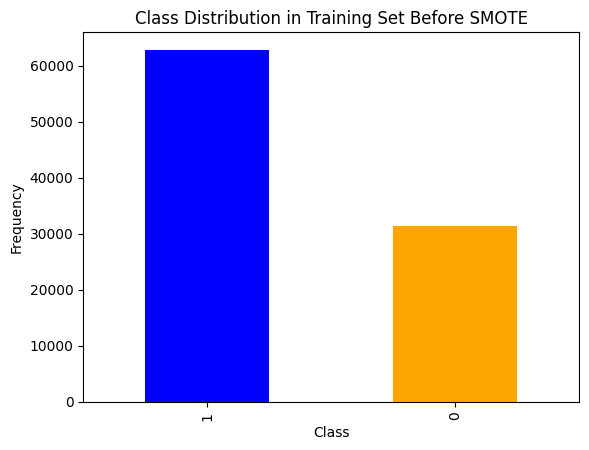

In [ ]:
# Split the data into training and test sets with 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.3, random_state=42)

# Display the class distribution in the training set before applying SMOTE
print("Class distribution in y_train before SMOTE:")
print(y_train.value_counts())

# Plot the class distribution in the training set before SMOTE
y_train.value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution in Training Set Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


### Step 9.1: Handling Class Imbalance with SMOTE

SMOTE is applied to the training data to create a balanced class distribution. This technique generates synthetic samples for the minority class by interpolating between existing samples, thereby balancing the dataset without simply duplicating existing samples.


Class distribution in y_train after SMOTE:
label
0    62847
1    62847
Name: count, dtype: int64


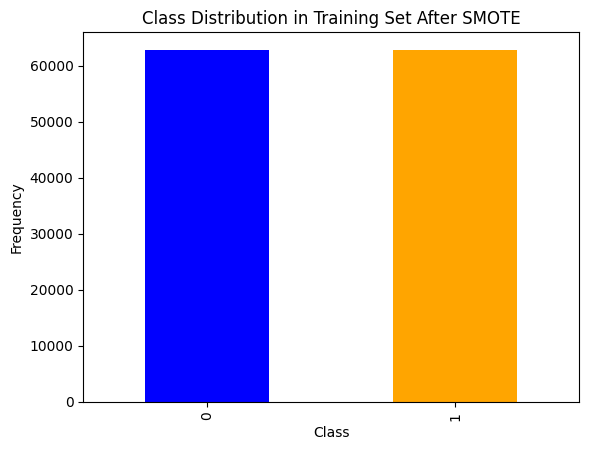

In [ ]:
# Initialize SMOTE with a fixed random state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to balance the classes
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display the class distribution in the training set after applying SMOTE
print("Class distribution in y_train after SMOTE:")
print(y_train_smote.value_counts())

# Plot the class distribution in the training set after SMOTE
y_train_smote.value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution in Training Set After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Full Body Analysis at Feature Level - Ensemble Models

## Random Forest Model Analysis

This section provides a detailed analysis of the Random Forest model applied to full body data at feature-level. A baseline model was initialized, then proceed to cross-validation, regularization, and hyperparameter tuning to identify the best parameters for the Random Forest model. The model's performance is evaluated on both resampled and non-resampled data using metrics such as accuracy, ROC-AUC, and confusion matrix.


### 1. Baseline Model Initialization and Training
A baseline `RandomForestClassifier`is initialized with default parameters and train it on the resampled training data. The `train_model` function is used for training and evaluation, which prints the performance metrics and generates visualisations such as the confusion matrix and log loss plots.

Accuracy: 0.991084032989078
ROC-AUC: 0.9979452417026269
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     13445
           1       1.00      0.99      0.99     26932

    accuracy                           0.99     40377
   macro avg       0.99      0.99      0.99     40377
weighted avg       0.99      0.99      0.99     40377



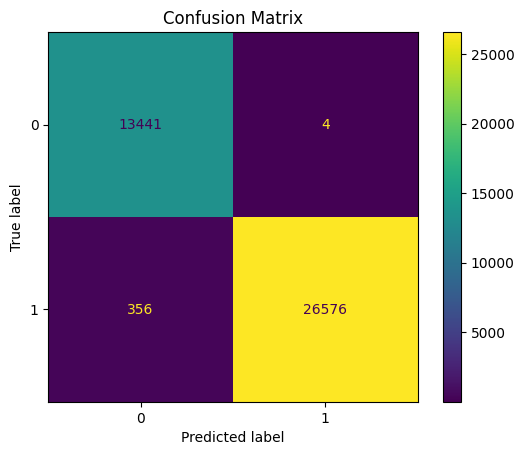

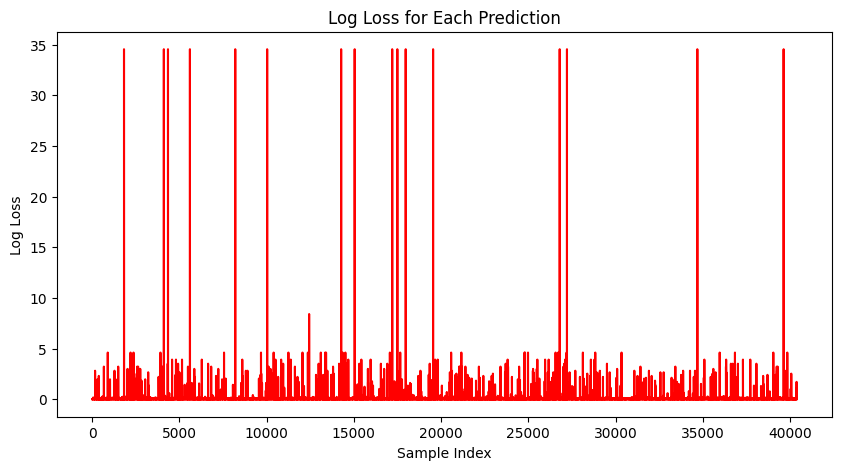

In [ ]:
# Initialize the baseline RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the baseline model using the resampled training data
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, rf_classifier)

### 2. Cross-Validation on Pre-SMOTEd Data

The `cross_validate_pre_smoted_data` function performs cross-validation on the Random Forest model using the pre-SMOTEd training data. Cross-validation helps evaluate the model's performance across multiple folds of the data, providing a more robust estimate of its generalization ability. The function also plots the accuracy scores for each fold and highlights the mean accuracy across all folds.

The purpose of cross-validating on pre-SMOTEd data is to compare model performance before and after addressing class imbalance. This helps in understanding whether applying SMOTE improves the model's performance.


In [ ]:
def cross_validate_pre_smoted_data(model, X_train, y_train, X_test, y_test, cv=5):
    """
    Cross-validate the model using pre-SMOTEd training data.

    Parameters:
    model: The machine learning model to be evaluated.
    X_train: Training feature set (before applying SMOTE).
    y_train: Training labels (before applying SMOTE).
    X_test: Testing feature set.
    y_test: Testing labels.
    cv: Number of cross-validation folds (default: 5).

    Returns:
    cv_scores: Array of accuracy scores for each fold.
    """
    # Initialize StratifiedKFold for cross-validation with shuffle enabled
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Use cross_val_score with custom scoring for accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(accuracy_score))

    # Print the cross-validation results
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")

    # Plot the cross-validation accuracy scores for each fold
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, cv + 1), cv_scores, marker='o', linestyle='-', color='b', label='Accuracy')
    plt.axhline(np.mean(cv_scores), linestyle='--', color='r', label=f'Mean Accuracy: {np.mean(cv_scores):.4f}')
    plt.title("Cross-Validation Accuracy Scores for Each Fold")
    plt.xlabel("Fold Number")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])  # Set y-axis limit from 0 to 1
    plt.legend()
    plt.grid(True)
    plt.show()

    return cv_scores

Cross-Validation Accuracy Scores: [0.99367517 0.99283981 0.99315804 0.9930387  0.99272018]
Mean Accuracy: 0.9931


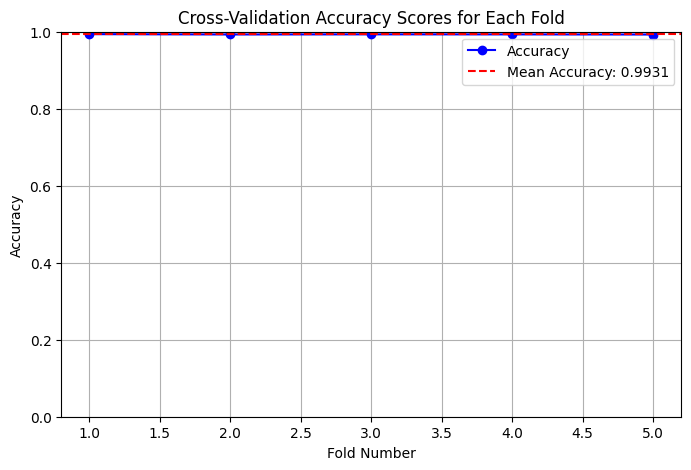

array([0.99367517, 0.99283981, 0.99315804, 0.9930387 , 0.99272018])

In [ ]:
# Cross-validate the Random Forest model using pre-SMOTEd training data
cross_validate_pre_smoted_data(rf_classifier, X_train, y_train, X_test, y_test, cv=5)

### 3. Regularization and Parameter Adjustment

The parameters of the Random Forest model were adjusted to control overfitting and improve performance. Regularization techniques include setting constraints on tree depth (`max_depth`), minimum samples required to split a node (`min_samples_split`), and minimum samples required at a leaf node (`min_samples_leaf`).


Accuracy: 0.9907868340887138
ROC-AUC: 0.9965112857819621
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     13445
           1       1.00      0.99      0.99     26932

    accuracy                           0.99     40377
   macro avg       0.99      0.99      0.99     40377
weighted avg       0.99      0.99      0.99     40377



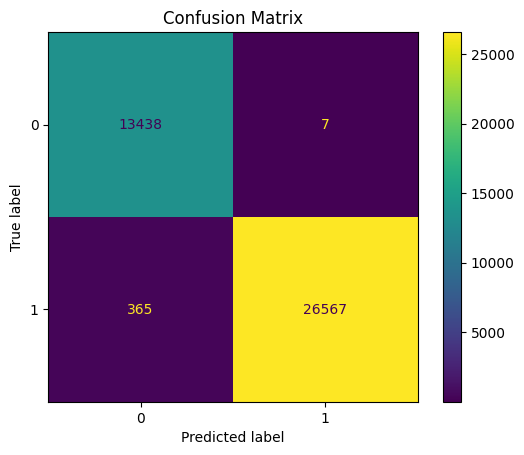

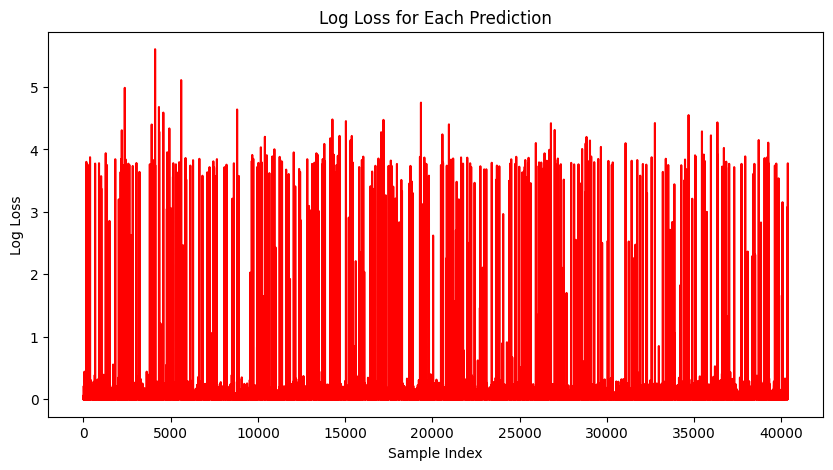

In [ ]:
# Adjust parameters for regularization
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Control tree depth
    min_samples_split=5,  # Minimum samples required to split a node
    min_samples_leaf=4,  # Minimum samples required at a leaf node
    max_features='sqrt',  # Use sqrt(features) at each split
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

# Train the model using the resampled training data with new parameters
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, rf_classifier)

### 4. Hyperparameter Tuning with Random Search

The `perform_random_search` function is used to perform hyperparameter tuning on the Random Forest model using Randomized Search. Random Search is an efficient method for exploring a large hyperparameter space by randomly sampling combinations of hyperparameters. This method helps identify the best set of hyperparameters to optimize model performance without the exhaustive computational cost of Grid Search.

In this function, a search space is defined (`param_distributions`) for the Random Forest model's key hyperparameters, such as `n_estimators`, `max_depth`, `min_samples_split`, and `max_features`. The function then performs cross-validation for each sampled combination and returns the best model along with its parameters and performance score.

In [ ]:
def perform_random_search(classifier, param_distributions, X_train, y_train, cv=5, n_iter=50, scoring=None, random_state=42):
    """
    Perform random search for hyperparameter tuning on the given classifier.

    Parameters:
    - classifier: The machine learning model to tune (e.g., RandomForestClassifier()).
    - param_distributions: Dictionary with hyperparameters and their ranges for random search.
    - X_train: Training feature data for fitting the model.
    - y_train: Training label data for fitting the model.
    - cv: Number of cross-validation folds (default: 5).
    - n_iter: Number of random parameter combinations to try (default: 50).
    - scoring: Scoring metric to evaluate the models (default: accuracy_score).
    - random_state: Random state for reproducibility (default: 42).

    Returns:
    - best_estimator: The best model found by the random search.
    - best_params: The best hyperparameters found by the random search.
    - best_score: The best cross-validation score achieved by the best model.
    """
    # Set the default scoring metric when not provided
    if scoring is None:
        scoring = make_scorer(accuracy_score)

    # Initialize RandomizedSearchCV with the specified parameters and scoring metric
    random_search = RandomizedSearchCV(
        estimator=classifier,
        param_distributions=param_distributions,
        n_iter=n_iter,  # Number of parameter combinations to sample
        scoring=scoring,  # Scoring metric to evaluate models
        cv=cv,  # Number of cross-validation folds
        verbose=2,  # Verbosity level for logging progress
        random_state=random_state,  # Set random state for reproducibility
        n_jobs=-1  # Use all available CPU cores for parallel processing
    )

    # Perform Random Search to find the best parameters
    random_search.fit(X_train, y_train)

    # Print the best parameters and cross-validation score found
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")

    # Return the best model, best parameters, and best cross-validation score
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

In [ ]:
# Step 1: Define the parameter grid for RandomForest
param_dist_rf = {
    'n_estimators': randint(100, 500),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of each tree
    'min_samples_split': randint(2, 10),  # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 5),  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider at each split
}

In [ ]:
# Step 2: Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Step 3: Perform Random Search for hyperparameter tuning
best_rf_model, best_rf_params, best_rf_score = perform_random_search(
    classifier=rf_classifier,
    param_distributions=param_dist_rf,
    X_train=X_train_smote,
    y_train=y_train_smote
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=314; total time= 2.3min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=443; total time= 2.6min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=443; total time= 3.1min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=291; total time= 2.0min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=148; total time= 1.3min
[CV] END max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=287; total time=10.9min
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=9, n_estimators=230; total time= 9.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=34

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time= 1.2min
[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=199; total time= 6.7min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=291; total time= 2.0min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=148; total time= 1.3min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=148; total time= 1.3min
[CV] END max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=287; total time=10.6min
[CV] END max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=6, n_estimators=428; total time=18.2min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=149; total time= 1.2min
[CV] END max_depth=20, max_features=log2

Accuracy: 0.9911830992891993
ROC-AUC: 0.9981437748511643
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     13445
           1       1.00      0.99      0.99     26932

    accuracy                           0.99     40377
   macro avg       0.99      0.99      0.99     40377
weighted avg       0.99      0.99      0.99     40377



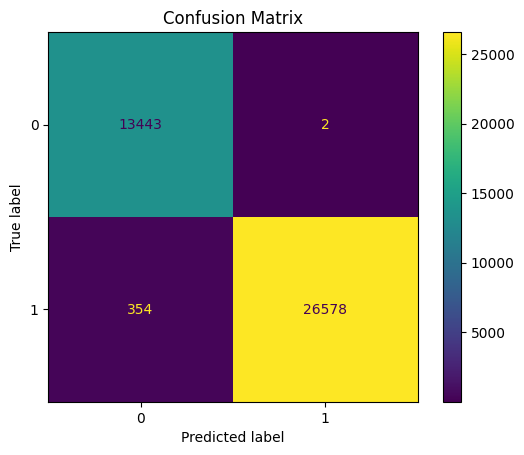

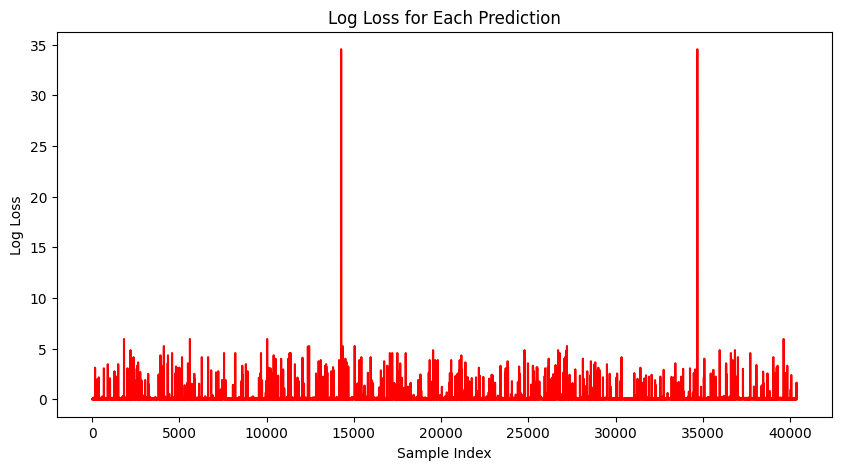

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time= 1.2min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=314; total time= 2.2min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=443; total time= 3.0min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=443; total time= 3.0min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=413; total time= 3.7min
[CV] END max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=150; total time= 1.2min
[CV] END max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=150; total time= 1.0min
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=9, n_estimators=230; total time= 9.0min
[CV] END max_depth=10, max_features=sqrt

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time= 1.2min
[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=199; total time= 6.7min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=291; total time= 2.1min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=148; total time= 1.3min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=148; total time= 1.3min
[CV] END max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=287; total time=10.4min
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=9, n_estimators=230; total time= 8.8min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=485; total time= 3.3min
[CV] END max_depth=10, max_features=sqrt

In [ ]:
# Step 4: Train and Evaluate the Best Model
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, best_rf_model)

## XGBoost Model Analysis

This section provides a detailed analysis of the XGBoost model applied to full-body data at the feature level. XGBoost is a powerful ensemble method that combines boosting and decision tree algorithms to handle complex data patterns and improve model performance. We start by initializing a baseline model, followed by hyperparameter tuning using Random Search to identify the best set of parameters for the model. The model is then evaluated using metrics such as accuracy, ROC-AUC, and confusion matrix.

### 1. Baseline Model Initialization and Training
We begin by initializing a baseline `XGBClassifier` with default parameters. The baseline model is trained using the training data, and its performance is evaluated on the test set. This provides a reference point for comparing the results of hyperparameter tuning and improvements in the model’s performance.

Accuracy: 0.9910097332639869
ROC-AUC: 0.9985780768567347
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      8938
           1       1.00      0.99      0.99     17980

    accuracy                           0.99     26918
   macro avg       0.99      0.99      0.99     26918
weighted avg       0.99      0.99      0.99     26918



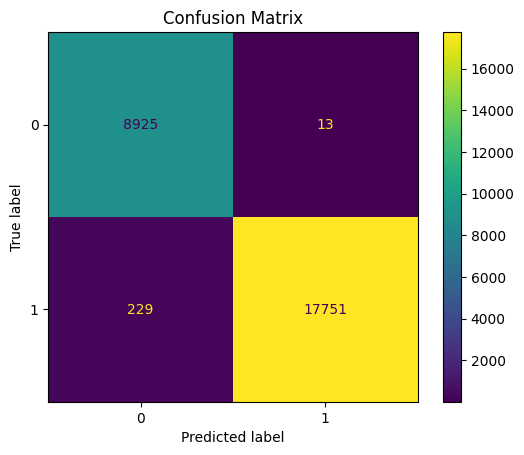

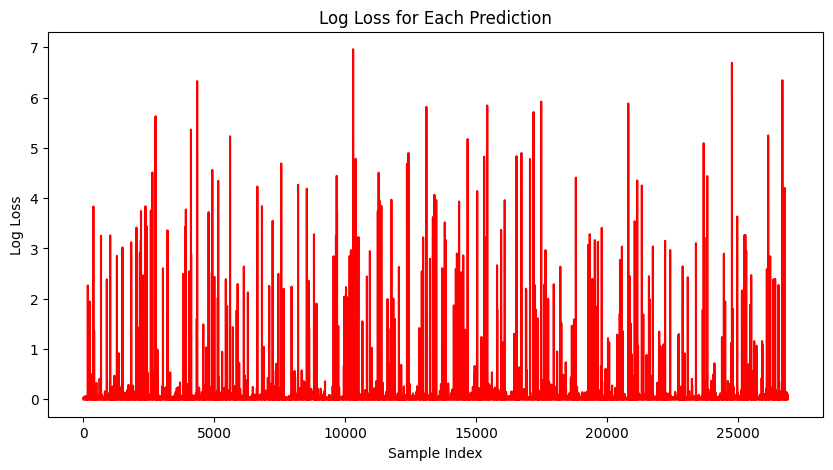

In [ ]:
# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model using the XGBoost classifier
trained_xgb = train_model(X_train, X_test, y_train, y_test, xgb_classifier)

### 2. Hyperparameter Tuning with Random Search

To optimize the performance of the XGBoost model, we use Random Search for hyperparameter tuning. The `perform_random_search` function explores a defined search space of hyperparameters and identifies the best combination that maximizes the model's performance.

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the ensemble
    'max_depth': [3, 5, 7, 9, 11],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate for gradient boosting
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of features used per tree
    'min_child_weight': [1, 3, 5, 7],  # Minimum sum of weights required to create a child node
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization term on weights
    'reg_lambda': [0, 0.01, 0.1, 1],  # L2 regularization term on weights
}

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform Random Search for hyperparameter tuning
best_xgb_model, best_xgb_params, best_xgb_score = perform_random_search(
    classifier=xgb_classifier,
    param_distributions=param_grid_xgb,
    X_train=X_train_smote,  # Training features after SMOTE
    y_train=y_train_smote,  # Training labels after SMOTE
    cv=5,  # 5-fold cross-validation
    n_iter=50,  # Number of iterations for random search
    scoring='accuracy'  # Scoring metric to optimize
)

# Output the best model details
print("Best XGBoost Model:", best_xgb_model)
print("Best Parameters for XGBoost:", best_xgb_params)
print("Best Score for XGBoost:", best_xgb_score)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Best Cross-Validation Score: 0.9932852800597507
Best XGBoost Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
      

### 3. Training and Evaluation of the Best Model

The best model identified from the Random Search is re-trained using the training data and evaluated on the test set. This step provides a comparison with the baseline model and shows the improvements achieved through hyperparameter tuning.


Accuracy: 0.991604131064715
ROC-AUC: 0.9987340981407549
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13445
           1       1.00      0.99      0.99     26932

    accuracy                           0.99     40377
   macro avg       0.99      0.99      0.99     40377
weighted avg       0.99      0.99      0.99     40377



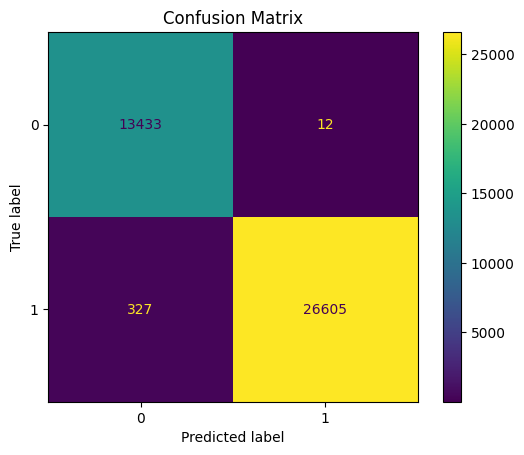

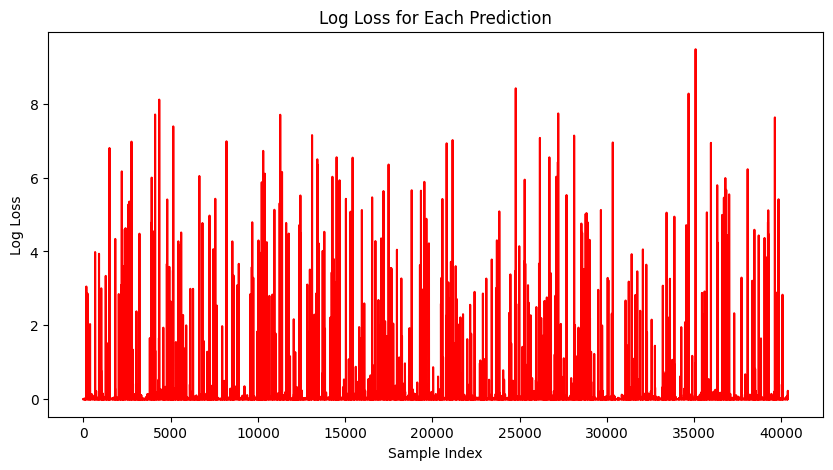

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  19.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=  16.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=  17.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=11, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.7; total time=  10.5s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=11, min_child_weight=5, n_estimators=400, reg_alpha=0.

[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=  25.7s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=  15.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=  16.0s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=11, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.7; total time=  10.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=0.1, subsample=0.6; total time=   7.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=11, min_child_weight=5, n_estimators=400, reg_alpha=0.1,

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=  18.8s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=  16.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=  17.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.05, max_depth=9, min_child_weight=7, n_estimators=400, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9; total time=  16.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=0.1, subsample=0.6; total time=   7.7s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=11, min_child_weight=5, n_estimators=100, reg_alph

[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=  26.2s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=  15.7s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.05, max_depth=9, min_child_weight=7, n_estimators=400, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9; total time=  16.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=11, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.7; total time=  10.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=0.1, subsample=0.6; total time=   7.7s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=11, min_child_weight=5, n_estimators=100, reg_alp

In [ ]:
# Train and evaluate the best XGBoost model from Random Search
trained_xgb = train_model(X_train_smote, X_test, y_train_smote, y_test, best_xgb_model)

# Segmented Body Analysis at Feature Level - Ensemble Models

## Lung-Segmented Image Processing and Feature Extraction

This section focuses on processing and extracting features from lung-segmented images (slices 120-260) for both PD-L1 positive and PD-L1 negative patients. The workflow involves loading the segmented slices, extracting features, and then combining these features for further analysis. The lung-segmented data is processed using specific slice ranges to ensure that only the relevant slices are included in the analysis.


In [ ]:
# Define paths to directories containing patient data
base_directory = 'C:\\Anonymized PD-L1'  # Path to the base directory where patient data is stored
positive_dir = os.path.join(base_directory, 'PD-L1 Positive')  # Subdirectory for PD-L1 positive patients
negative_dir = os.path.join(base_directory, 'PD-L1 Negative')  # Subdirectory for PD-L1 negative patients

# Directory where intermediate results will be saved, such as preprocessed slices and extracted features
output_directory = 'C:\\Anonymized PD-L1 Output1'  # Change this as necessary for the output directory

# Log file to keep track of processed patients
log_file = 'processed_patients1.log'  # Log file to record patient IDs that have been processed

### Processing Lung-Segmented Data

The following code processes lung-segmented DICOM slices for PD-L1 positive and negative patients. The slice range is set to `(120, 260)` to focus on the lung region. Each patient's slices are resized to a standard shape of `(512, 512)` for uniformity. The `process_directory_incremental` function loads and preprocesses these slices, saving intermediate results in the specified output directory.


In [ ]:
print("Processing PD-L1 Positive (Lung Segmented)...")
positive_data_lung_segmented = process_directory_incremental(
    base_dir=positive_dir,
    output_dir=output_directory,
    log_file=log_file,
    target_shape=(512, 512),  # Resize to 512x512
    slice_range=(120, 260),  # Specify slice range for lung-segmented data
    data_type='lung_segmented'  # Indicate that the data is lung-segmented
)

# Process the negative patient directory for lung-segmented data
print("Processing PD-L1 Negative (Lung Segmented)...")
negative_data_lung_segmented = process_directory_incremental(
    base_dir=negative_dir,
    output_dir=output_directory,
    log_file=log_file,
    target_shape=(512, 512),  # Resize to 512x512
    slice_range=(120, 260),  # Specify slice range for lung-segmented data
    data_type='lung_segmented'  # Indicate that the data is lung-segmented
)

Processing PD-L1 Positive (Lung Segmented)...
Skipping Patient 1 (already processed)...
Skipping Patient 10 (already processed)...
Skipping Patient 100 (already processed)...
Skipping Patient 101 (already processed)...
Skipping Patient 102 (already processed)...
Skipping Patient 103 (already processed)...
Skipping Patient 104 (already processed)...
Skipping Patient 105 (already processed)...
Skipping Patient 106 (already processed)...
Skipping Patient 107 (already processed)...
Skipping Patient 108 (already processed)...
Skipping Patient 109 (already processed)...
Skipping Patient 11 (already processed)...
Skipping Patient 110 (already processed)...
Skipping Patient 111 (already processed)...
Skipping Patient 112 (already processed)...
Skipping Patient 113 (already processed)...
Skipping Patient 114 (already processed)...
Skipping Patient 115 (already processed)...
Skipping Patient 116 (already processed)...
Skipping Patient 117 (already processed)...
Skipping Patient 118 (already proc

## Loading, Combining, and Labeling Extracted Features

After processing the lung-segmented images for both PD-L1 positive and negative patients, the extracted features are loaded from the output directory. The features for positive and negative patients are then combined into a single feature matrix, and labels are assigned to indicate whether each sample corresponds to a PD-L1 positive or negative patient.


In [ ]:
# Load extracted features for PD-L1 positive patients from the output directory
positive_data = load_features_from_output_dir(positive_dir, output_directory)

# Load extracted features for PD-L1 negative patients from the output directory
negative_data = load_features_from_output_dir(negative_dir, output_directory)

# Combine positive and negative features, and assign labels
# `features` is the combined feature matrix, and `labels` is the corresponding label array (1 for positive, 0 for negative).
features, labels = label_features({**positive_data, **negative_data}, positive_dir, negative_dir)

Loading features for Patient 1 from C:\Anonymized PD-L1 Output1\Patient 1_features.npy
Loaded 141 features for Patient 1
Loading features for Patient 10 from C:\Anonymized PD-L1 Output1\Patient 10_features.npy
Loaded 141 features for Patient 10
Loading features for Patient 100 from C:\Anonymized PD-L1 Output1\Patient 100_features.npy
Loaded 141 features for Patient 100
Loading features for Patient 101 from C:\Anonymized PD-L1 Output1\Patient 101_features.npy
Loaded 141 features for Patient 101
Loading features for Patient 102 from C:\Anonymized PD-L1 Output1\Patient 102_features.npy
Loaded 141 features for Patient 102
Loading features for Patient 103 from C:\Anonymized PD-L1 Output1\Patient 103_features.npy
Loaded 141 features for Patient 103
Loading features for Patient 104 from C:\Anonymized PD-L1 Output1\Patient 104_features.npy
Loaded 141 features for Patient 104
Loading features for Patient 105 from C:\Anonymized PD-L1 Output1\Patient 105_features.npy
Loaded 141 features for Patie

## Feature Preparation, Scaling, and Selection using RandomForest

This code block prepares and selects features for machine learning modeling using a RandomForest classifier. The workflow involves:

1. **Flattening and DataFrame Conversion**: Converting nested dictionaries of feature values into a structured tabular format (DataFrame).
2. **Handling Missing Values**: Filling missing values to ensure a complete dataset.
3. **Feature Scaling**: Applying standard scaling to normalize feature values.
4. **Train-Test Split**: Splitting the data into training and test sets for model evaluation.
5. **Feature Importance Computation**: Using a RandomForest classifier to identify important features based on feature importances.
6. **Feature Selection**: Selecting features that exceed a specified importance threshold.

The selected features will form a reduced feature set, which is more relevant for classification, thereby improving model performance and interpretability.


In [ ]:
# Step 1: Flatten the OrderedDicts and convert to a DataFrame
flattened_features = []  # Initialize an empty list to hold flattened feature sets

for feature_set in features:
    flat_dict = {}  # Create an empty dictionary for each feature set
    for key, value in feature_set.items():
        try:
            flat_dict[key] = float(value)  # Convert values to float
        except (ValueError, TypeError):
            continue  # Skip non-numeric values
    flattened_features.append(flat_dict)  # Append the flattened feature set to the list

# Convert the list of flattened dictionaries to a DataFrame
features_df = pd.DataFrame(flattened_features)
print(f"Total number of features before selection: {features_df.shape[1]}")

# Step 2: Handle missing values by replacing NaNs with zeros
features_df.fillna(0, inplace=True)

# Step 3: Scale the features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)  # Scale features to have mean 0 and variance 1

# Step 4: Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Step 5: Train a RandomForest Classifier and compute feature importances
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize RandomForest
rf_classifier.fit(X_train, y_train)  # Train the model
feature_importances = rf_classifier.feature_importances_  # Get feature importance scores

# Step 6: Select important features based on a threshold
importance_threshold = 0.01  # Define a threshold for selecting features
selected_features = np.where(feature_importances > importance_threshold)[0]  # Get indices of selected features
selected_feature_names = features_df.columns[selected_features]  # Get the names of selected features

# Output selected features
print(f"Number of selected features: {len(selected_features)}")
print(f"Selected feature indices: {selected_features}")
print(f"Selected feature names: {list(selected_feature_names)}")

Total number of features before selection: 98
Number of selected features: 38
Selected feature indices: [ 0  3  7 20 47 48 49 50 51 54 55 56 58 59 60 61 65 66 67 69 70 71 72 73
 74 75 76 77 81 82 83 86 87 88 89 90 91 92]
Selected feature names: ['diagnostics_Image-original_Mean', 'diagnostics_Mask-original_VoxelNum', 'original_firstorder_Energy', 'original_firstorder_TotalEnergy', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphas

## Data Preparation

The data preparation involves creating a new DataFrame with selected features, combining these features with corresponding labels, saving the results for future use, and reloading them to separate the features and labels again for modeling purposes.

In [ ]:
# Step 1: Create a new DataFrame containing only the selected features
# The 'selected_feature_names' contains the list of features that were deemed important in the previous step.
selected_features_df = features_df[selected_feature_names]

# Display the structure and details of the new DataFrame
# This allows us to verify that the new DataFrame contains only the selected features.
selected_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43142 entries, 0 to 43141
Data columns (total 38 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Image-original_Mean                     43142 non-null  float64
 1   diagnostics_Mask-original_VoxelNum                  43142 non-null  float64
 2   original_firstorder_Energy                          43142 non-null  float64
 3   original_firstorder_TotalEnergy                     43142 non-null  float64
 4   original_gldm_DependenceEntropy                     43142 non-null  float64
 5   original_gldm_DependenceNonUniformity               43142 non-null  float64
 6   original_gldm_DependenceNonUniformityNormalized     43142 non-null  float64
 7   original_gldm_DependenceVariance                    43142 non-null  float64
 8   original_gldm_GrayLevelNonUniformity                43142 non-null  float64


In [ ]:
# Step 2: Create a DataFrame from the labels array
labels_df = pd.DataFrame(labels, columns=['label'])  # Create a DataFrame for labels with a single column 'label'

# Combine the selected features and labels into a single DataFrame
combined_df = pd.concat([selected_features_df, labels_df], axis=1)  # Concatenate along columns

# Save the combined DataFrame to a CSV file for future use
combined_df.to_csv('select_radiomics_features_labels.csv', index=False)  # Save without row indices
print("Combined features and labels saved to 'select_radiomics_features_labels.csv'")

# Display the structure and information of the combined DataFrame
combined_df.info()  # Check the structure and data types of the combined DataFrame

Combined features and labels saved to 'select_radiomics_features_labels.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43142 entries, 0 to 43141
Data columns (total 39 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Image-original_Mean                     43142 non-null  float64
 1   diagnostics_Mask-original_VoxelNum                  43142 non-null  float64
 2   original_firstorder_Energy                          43142 non-null  float64
 3   original_firstorder_TotalEnergy                     43142 non-null  float64
 4   original_gldm_DependenceEntropy                     43142 non-null  float64
 5   original_gldm_DependenceNonUniformity               43142 non-null  float64
 6   original_gldm_DependenceNonUniformityNormalized     43142 non-null  float64
 7   original_gldm_DependenceVariance                    43142 non-null  float64
 8  

In [ ]:
# Step 3: Re-load the combined features and labels from the CSV file
combined_df = pd.read_csv('select_radiomics_features_labels.csv')  # Load the CSV file into a new DataFrame

# Display the structure and information of the re-loaded DataFrame
combined_df.info()  # Check that the data has been correctly reloaded with the expected columns and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43142 entries, 0 to 43141
Data columns (total 39 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Image-original_Mean                     43142 non-null  float64
 1   diagnostics_Mask-original_VoxelNum                  43142 non-null  float64
 2   original_firstorder_Energy                          43142 non-null  float64
 3   original_firstorder_TotalEnergy                     43142 non-null  float64
 4   original_gldm_DependenceEntropy                     43142 non-null  float64
 5   original_gldm_DependenceNonUniformity               43142 non-null  float64
 6   original_gldm_DependenceNonUniformityNormalized     43142 non-null  float64
 7   original_gldm_DependenceVariance                    43142 non-null  float64
 8   original_gldm_GrayLevelNonUniformity                43142 non-null  float64


In [ ]:
# Step 4: Separate the features and labels from the re-loaded combined DataFrame
features_df = combined_df.drop('label', axis=1)  # Drop the 'label' column to create the features DataFrame
labels = combined_df['label']  # Extract the 'label' column as the labels array

# Display the structure and information of the features DataFrame
features_df.info()  # Check the structure and ensure all features are correctly separated

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43142 entries, 0 to 43141
Data columns (total 38 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Image-original_Mean                     43142 non-null  float64
 1   diagnostics_Mask-original_VoxelNum                  43142 non-null  float64
 2   original_firstorder_Energy                          43142 non-null  float64
 3   original_firstorder_TotalEnergy                     43142 non-null  float64
 4   original_gldm_DependenceEntropy                     43142 non-null  float64
 5   original_gldm_DependenceNonUniformity               43142 non-null  float64
 6   original_gldm_DependenceNonUniformityNormalized     43142 non-null  float64
 7   original_gldm_DependenceVariance                    43142 non-null  float64
 8   original_gldm_GrayLevelNonUniformity                43142 non-null  float64


## Splitting Data and Balancing Classes with SMOTE

This section outlines the steps to split the dataset into training and test sets, check the class distribution before and after balancing, and apply SMOTE to address class imbalance. Class imbalance is a common issue in medical datasets where one class (PD-L1 positive) may have significantly fewer samples than the other class (PD-L1 negative). SMOTE helps generate synthetic samples for the minority class, improving model performance and reducing bias.


Class distribution in y_train before SMOTE:
label
1    20246
0     9953
Name: count, dtype: int64


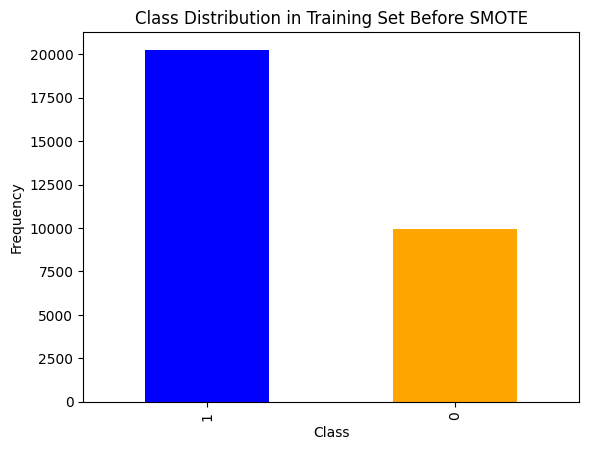

In [ ]:
# Step 1: Split the data into training and test sets
# The data is split with 70% allocated for training and 30% for testing.
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.3, random_state=42)

# Display the class distribution in the training set before applying SMOTE
print("Class distribution in y_train before SMOTE:")
print(y_train.value_counts())  # Print the counts of each class (0 and 1)

# Visualize the class distribution in the training set before SMOTE
y_train.value_counts().plot(kind='bar', color=['blue', 'orange'])  # Create a bar plot for class distribution
plt.title('Class Distribution in Training Set Before SMOTE')  # Set plot title
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()  # Display the plot

Class distribution in y_train after SMOTE:
label
1    20246
0    20246
Name: count, dtype: int64


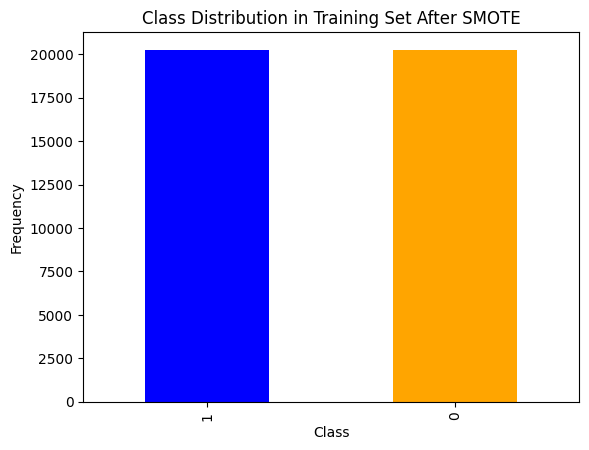

In [ ]:
# Step 2: Initialize and apply SMOTE to the training data
smote = SMOTE(random_state=42)  # Initialize SMOTE with a fixed random state for reproducibility

# Apply SMOTE to the training data to generate synthetic samples for the minority class
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display the class distribution in the training set after applying SMOTE
print("Class distribution in y_train after SMOTE:")
print(y_train_smote.value_counts())  # Print the counts of each class (e.g., 0 and 1) after applying SMOTE

# Visualize the class distribution in the training set after SMOTE
y_train_smote.value_counts().plot(kind='bar', color=['blue', 'orange'])  # Create a bar plot for class distribution
plt.title('Class Distribution in Training Set After SMOTE')  # Set plot title
plt.xlabel('Class')  # Label the x-axis as 'Class'
plt.ylabel('Frequency')  # Label the y-axis as 'Frequency'
plt.show()  # Display the plot

## Random Search Modelling for Lung Segmented Data at Feature Level

This section provides a detailed analysis of the Random Forest model applied to lung-segmented data at feature-level. A baseline model was initialized, then proceed to cross-validation, regularization, and hyperparameter tuning to identify the best parameters for the Random Forest model. The model's performance is evaluated on both resampled and non-resampled data using metrics such as accuracy, ROC-AUC, and confusion matrix.

### 1. Baseline Model Initialization and Training
A baseline `RandomForestClassifier`is initialized with default parameters and train it on the resampled training data. The `train_model` function is used for training and evaluation, which prints the performance metrics and generates visualisations such as the confusion matrix and log loss plots.

Accuracy: 0.7117360735532721
ROC-AUC: 0.7616372139422795
              precision    recall  f1-score   support

           0       0.55      0.61      0.58      4158
           1       0.80      0.76      0.78      8785

    accuracy                           0.71     12943
   macro avg       0.68      0.68      0.68     12943
weighted avg       0.72      0.71      0.72     12943



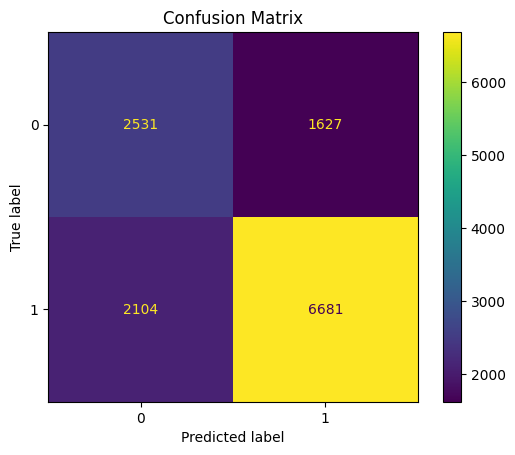

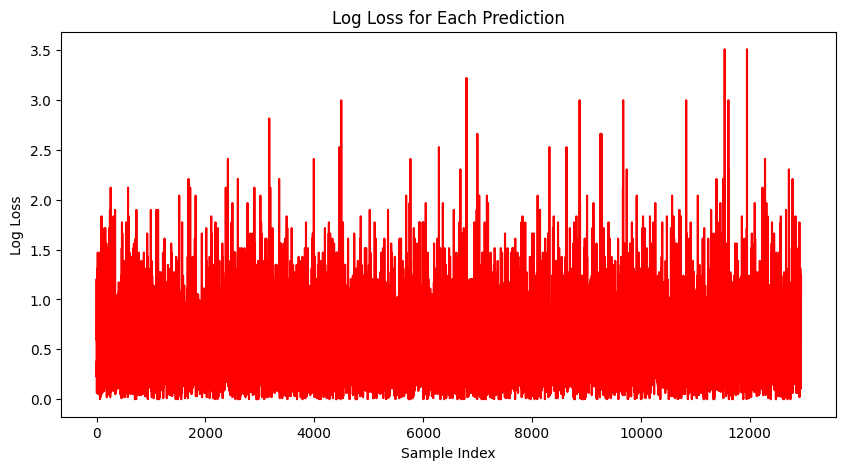

In [ ]:
# Step 1: Baseline Model Initialization and Training
# Initialize the RandomForestClassifier with a fixed random state for reproducibility
rf_classifier = RandomForestClassifier(random_state=42)

# Train the baseline model using the resampled training data (balanced using SMOTE)
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, rf_classifier)

### 2. Cross Validation

The cross_validate_pre_smoted_data function performs cross-validation on the Random Forest model using the pre-SMOTEd training data. Cross-validation helps evaluate the model's performance across multiple folds of the data, providing a more robust estimate of its generalization ability. The function also plots the accuracy scores for each fold and highlights the mean accuracy across all folds.

The purpose of cross-validating on pre-SMOTEd data is to compare model performance before and after addressing class imbalance. This helps in understanding whether applying SMOTE improves the model's performance.

Cross-Validation Accuracy Scores: [0.76034078 0.7629337  0.74611015 0.75611262 0.76488022]
Mean Accuracy: 0.7581


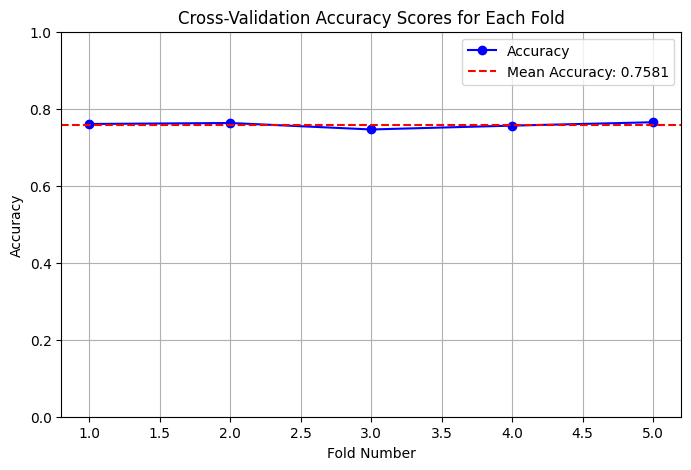

array([0.76034078, 0.7629337 , 0.74611015, 0.75611262, 0.76488022])

In [ ]:
# Step 2: Cross-Validation on Pre-SMOTEd Data
cross_validate_pre_smoted_data(rf_classifier, X_train_smote, y_train_smote, X_test, y_test, cv=5)

### Regularization

The parameters of the Random Forest model were adjusted to control overfitting and improve performance. Regularization techniques include setting constraints on tree depth (max_depth), minimum samples required to split a node (min_samples_split), and minimum samples required at a leaf node (min_samples_leaf).

Accuracy: 0.6451363671482655
ROC-AUC: 0.6919183706320873
              precision    recall  f1-score   support

           0       0.46      0.57      0.51      4158
           1       0.77      0.68      0.72      8785

    accuracy                           0.65     12943
   macro avg       0.61      0.62      0.61     12943
weighted avg       0.67      0.65      0.65     12943



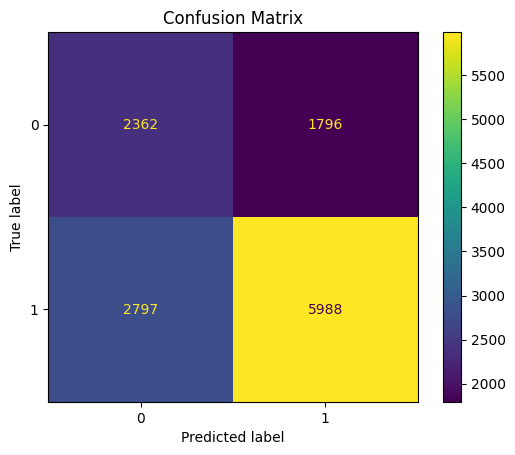

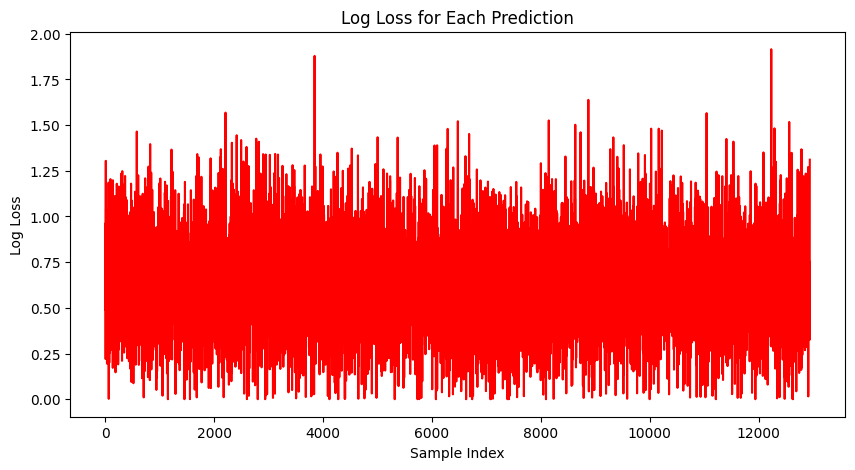

In [ ]:
# Step 3: Regularization and Parameter Adjustment
rf_classifier = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest
    max_depth=10,              # Maximum depth of the tree
    min_samples_split=5,       # Minimum samples required to split a node
    min_samples_leaf=4,        # Minimum samples required at a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    random_state=42,           # Random state for reproducibility
    class_weight='balanced'    # Automatically adjust weights inversely proportional to class frequencies
)

# Train the regularized model using the resampled training data
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, rf_classifier)

### Hyperparameter Tuning with Random Search

Random search is used to find the optimal hyperparameters for the RandomForest model. A wide range of hyperparameters is explored, and the best combination is selected based on cross-validation performance.


In [ ]:
# Step 4a: Define the parameter grid for RandomForest
param_dist_rf = {
    'n_estimators': randint(100, 500),           # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],     # Maximum depth of the tree
    'min_samples_split': randint(2, 10),         # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 5),           # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None]       # Number of features to consider at each split
}

In [ ]:
# Step 4b: Initialize RandomForestClassifier for Random Search
rf_classifier = RandomForestClassifier(random_state=42)

# Step 4c: Perform Random Search to find the best hyperparameters
best_rf_model, best_rf_params, best_rf_score = perform_random_search(
    classifier=rf_classifier,
    param_distributions=param_dist_rf,
    X_train=X_train_smote,
    y_train=y_train_smote
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time=  35.1s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=314; total time=  58.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=443; total time= 1.3min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=443; total time= 1.3min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=291; total time=  58.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=148; total time=  34.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=148; total time=  36.0s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=15

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time=  36.1s
[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=199; total time= 3.9min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=413; total time= 1.7min
[CV] END max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=287; total time= 7.0min
[CV] END max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=6, n_estimators=428; total time=10.7min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=149; total time=  28.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=149; total time=  29.7s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=153; total time=  31.8s
[CV] END max_depth=10, max_features=log2

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time=  36.0s
[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=199; total time= 3.8min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=413; total time= 1.7min
[CV] END max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=287; total time= 6.7min
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=9, n_estimators=230; total time= 5.5min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=485; total time= 1.5min
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=363; total time= 8.5min
[CV] END max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=289; total time= 6.8min
[CV] END max_depth=40, max_features=sqrt

Accuracy: 0.7274974889901877
ROC-AUC: 0.773249720830825
              precision    recall  f1-score   support

           0       0.57      0.60      0.59      4158
           1       0.81      0.79      0.80      8785

    accuracy                           0.73     12943
   macro avg       0.69      0.69      0.69     12943
weighted avg       0.73      0.73      0.73     12943



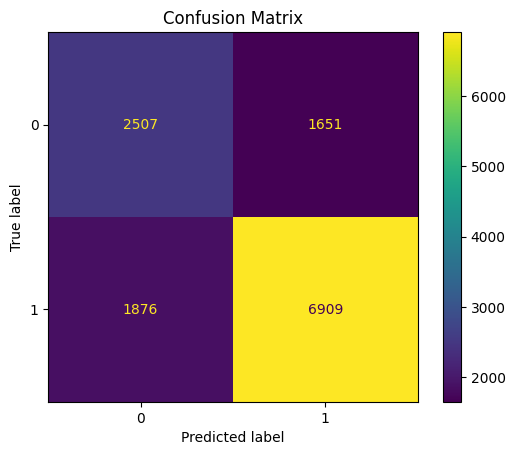

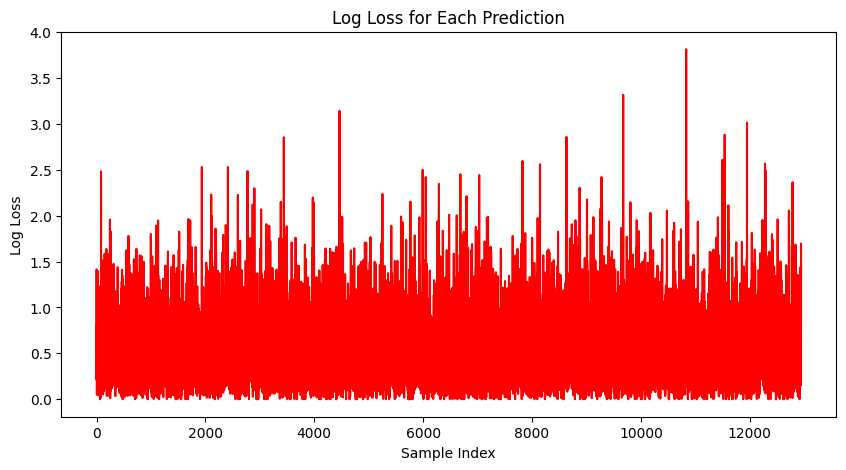

In [ ]:
# Step 5: Train and Evaluate the Best Model
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, best_rf_model)

## XGBoost Modeling for Lung-Segmented Data

The following steps outline the process of building and fine-tuning an XGBoost model for classifying PD-L1 expression levels using lung-segmented features. The workflow includes:

1. **Baseline Model Initialization and Training**: Initialize and train a baseline XGBoost model using the SMOTE-resampled training data.
2. **Hyperparameter Tuning with Random Search**: Perform random search to find the optimal hyperparameters for the XGBoost model.
3. **Training and Evaluating the Best Model**: Train the model with the best hyperparameters and evaluate its performance on the test set.


### 1. Baseline Model Initialization and Training

Accuracy: 0.6938885884261763
ROC-AUC: 0.7141340636218267
              precision    recall  f1-score   support

           0       0.53      0.49      0.51      4158
           1       0.77      0.79      0.78      8785

    accuracy                           0.69     12943
   macro avg       0.65      0.64      0.64     12943
weighted avg       0.69      0.69      0.69     12943



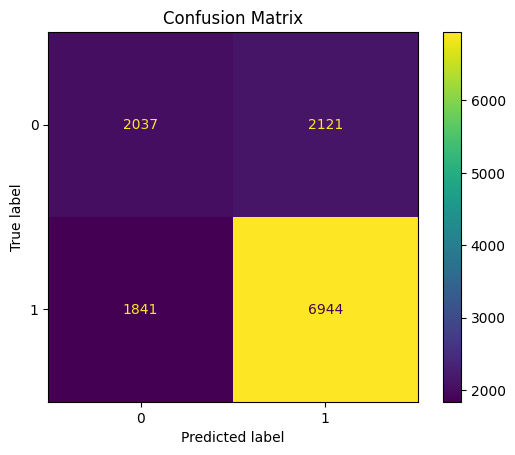

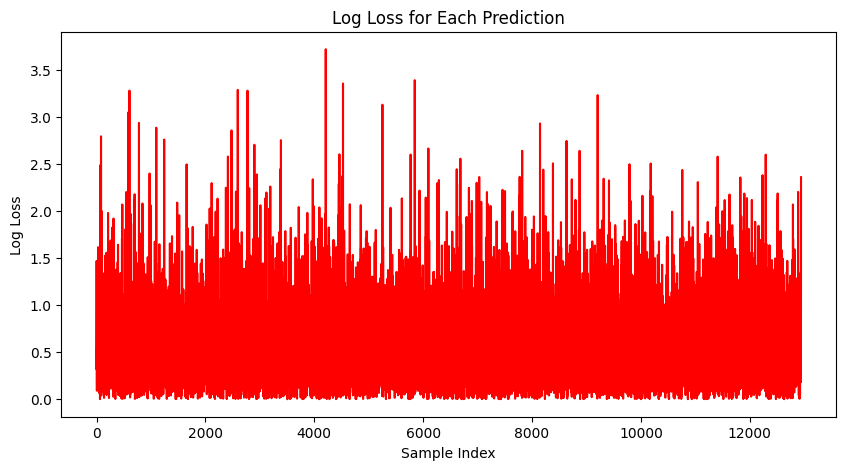

In [ ]:
# Step 1: Baseline Model Initialization and Training

# Initialize the XGBoost classifier with a fixed random state and logloss evaluation metric
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model using the SMOTE-resampled training data and evaluate its performance on the test set
trained_xgb = train_model(X_train_smote, X_test, y_train_smote, y_test, xgb_classifier)

### 2. Hyperparameter Tuning with Random Search

Random search is used to explore a wide range of hyperparameters to identify the optimal configuration for the XGBoost model. This step involves defining a parameter grid and running multiple iterations to find the best combination of hyperparameters.


In [ ]:
# Step 2a: Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [3, 5, 7, 9, 11],              # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Learning rate for weight updates
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],     # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of features used per tree
    'min_child_weight': [1, 3, 5, 7],           # Minimum sum of weights for child nodes
    'gamma': [0, 0.1, 0.2, 0.3],                # Minimum loss reduction required to make a split
    'reg_alpha': [0, 0.01, 0.1, 1],             # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1]             # L2 regularization
}

# Initialize the XGBoost classifier again for Random Search
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Step 2b: Perform Random Search to find the best hyperparameters for the XGBoost model
best_xgb_model, best_xgb_params, best_xgb_score = perform_random_search(
    classifier=xgb_classifier,
    param_distributions=param_grid_xgb,  # Parameter grid for random search
    X_train=X_train_smote,               # Training features (after SMOTE)
    y_train=y_train_smote,               # Training labels (after SMOTE)
    cv=5,                                # 5-fold cross-validation
    n_iter=50,                           # Number of random parameter combinations to try
    scoring='accuracy'                   # Scoring metric for evaluation
)

# Output the best model and hyperparameters found from Random Search
print("Best XGBoost Model:", best_xgb_model)
print("Best Parameters for XGBoost:", best_xgb_params)
print("Best Score for XGBoost:", best_xgb_score)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Best Cross-Validation Score: 0.7737368580731209
Best XGBoost Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
      

Accuracy: 0.7211620180792706
ROC-AUC: 0.7541957368081442
              precision    recall  f1-score   support

           0       0.57      0.53      0.55      4158
           1       0.79      0.81      0.80      8785

    accuracy                           0.72     12943
   macro avg       0.68      0.67      0.67     12943
weighted avg       0.72      0.72      0.72     12943



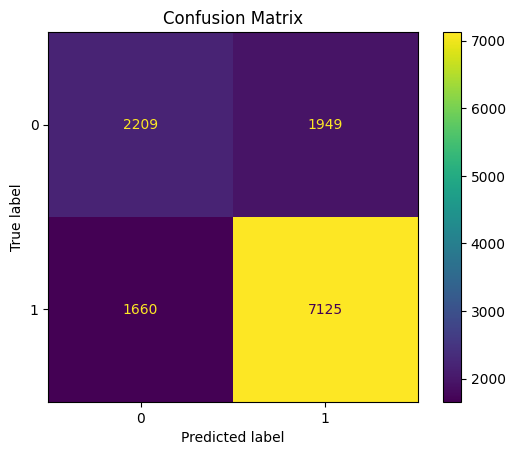

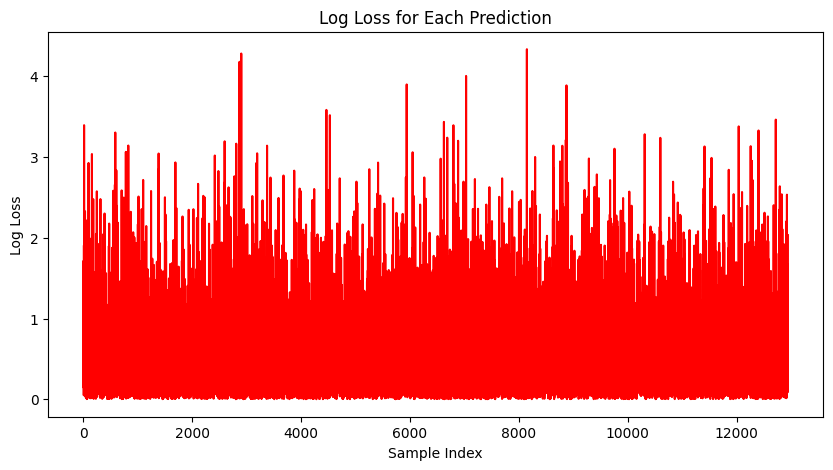

[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   3.7s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.05, max_depth=9, min_child_weight=7, n_estimators=400, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9; total time=   4.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=11, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.7; total time=   4.9s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=11, min_child_weight=5, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.9; total time=   3.4s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=11, min_child_weight=5, n_estimators=100, reg_al

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=11, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.7; total time=   5.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, reg_lambda=0.1, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=11, min_child_weight=5, n_estimators=400, reg_alpha=0.

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.01, reg_lambda=1, subsample=0.9; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=11, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.7; total time=   5.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=1, r

In [ ]:
# Step 3: Train and Evaluate the Best Model using the optimal hyperparameters
trained_xgb = train_model(X_train_smote, X_test, y_train_smote, y_test, best_xgb_model)


# Full-Body Analysis at Feature Level - Deep Learning

This section covers the development of a Fully Connected Neural Network (FCNN) for full-body deep learning analysis. The process starts by building and training a baseline FCNN model for binary classification, followed by hyperparameter tuning to improve model performance. Each model is evaluated using metrics such as accuracy, ROC-AUC, and confusion matrix, along with visualizations for training loss and validation loss.



### Function Definition: Building and Training the FCNN Model

The `build_and_train_fcnn` function builds, trains, and evaluates a Fully Connected Neural Network for classification. It allows dynamic adjustments of hyperparameters such as the number of hidden layers, activation functions, dropout rates, and optimizers. This function will be used throughout the analysis to build different versions of the FCNN model.

In [ ]:
def build_and_train_fcnn(X_train, X_test, y_train, y_test, input_dim,
                         hidden_layers=[128, 64, 32],
                         activation='relu',
                         dropout_rates=[0.3, 0.3],
                         optimizer='adam',
                         loss='binary_crossentropy',
                         epochs=50,
                         batch_size=32):
    """
    Builds, trains, and evaluates a Fully Connected Neural Network (FCNN) for binary classification with dynamic hyperparameters.

    Parameters:
    - X_train: Training feature data
    - X_test: Testing feature data
    - y_train: Training labels
    - y_test: Testing labels
    - input_dim: Number of input features
    - hidden_layers: List of units for each hidden layer
    - activation: Activation function for hidden layers
    - dropout_rates: List of dropout rates for each dropout layer
    - optimizer: Optimizer for training
    - loss: Loss function for training
    - epochs: Number of epochs for training
    - batch_size: Batch size for training

    Returns:
    - model: The trained FCNN model
    - history: Training history object
    """
    # Create the FCNN model
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Define the input layer

    # Dynamically add hidden layers and dropout
    for i, units in enumerate(hidden_layers):
        model.add(Dense(units, activation=activation))
        if i < len(dropout_rates):
            model.add(Dropout(dropout_rates[i]))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy}')

    # Predict probabilities and compute confusion matrix
    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype("int32")
    cm = confusion_matrix(y_test, y_pred)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix for FCNN')
    plt.show()

    # Calculate and plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f'ROC-AUC Score: {roc_auc}')


    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, history

### 1. Baseline Model Training and Evaluation

Build and train a baseline FCNN model with two hidden layers using the `ReLU` activation function. Dropout layers are included to prevent overfitting, and the model is optimized using the Adam optimizer. The model is trained on standardized data, and its performance is evaluated on the test set.

In [ ]:
combined_df = pd.read_csv('full_radiomics_features_labels.csv')
# Separate the features and labels from the re-loaded combined DataFrame
features_df = combined_df.drop('label', axis=1)  # Drop the 'label' column to create the features DataFrame
labels = combined_df['label']  # Extract the 'label' column as the labels array

Epoch 1/50
6730/6730 [==============================] - 8s 1ms/step - loss: 0.0729 - accuracy: 0.9803 - val_loss: 0.0556 - val_accuracy: 0.9861
Epoch 2/50
6730/6730 [==============================] - 7s 1ms/step - loss: 0.0599 - accuracy: 0.9838 - val_loss: 0.0531 - val_accuracy: 0.9861
Epoch 3/50
6730/6730 [==============================] - 7s 1ms/step - loss: 0.0574 - accuracy: 0.9848 - val_loss: 0.0478 - val_accuracy: 0.9874
Epoch 4/50
6730/6730 [==============================] - 7s 1ms/step - loss: 0.0556 - accuracy: 0.9851 - val_loss: 0.0528 - val_accuracy: 0.9861
Epoch 5/50
6730/6730 [==============================] - 7s 1ms/step - loss: 0.0551 - accuracy: 0.9855 - val_loss: 0.0507 - val_accuracy: 0.9884
Epoch 6/50
6730/6730 [==============================] - 7s 1ms/step - loss: 0.0528 - accuracy: 0.9860 - val_loss: 0.0472 - val_accuracy: 0.9877
Epoch 7/50
6730/6730 [==============================] - 7s 1ms/step - loss: 0.0532 - accuracy: 0.9861 - val_loss: 0.0477 - val_accuracy:

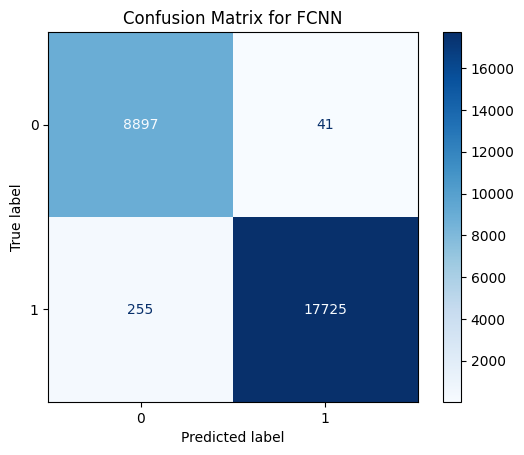

ROC-AUC Score: 0.996972329589253


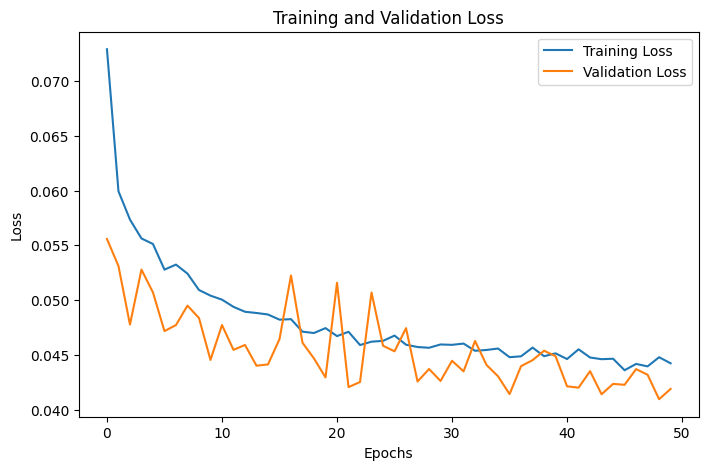

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build, train, and evaluate the baseline FCNN model
fcnn_model, fcnn_history = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],  # Number of input features
    hidden_layers=[128, 64],  # Two hidden layers
    activation='relu',  # ReLU activation function for hidden layers
    dropout_rates=[0.3, 0.2],  # Dropout rates for regularization
    optimizer='adam',  # Adam optimizer
    epochs=50,  # Train for 50 epochs
    batch_size=16  # Batch size of 16
)

### 2. First Hyperparameter Tuning

In the first hyperparameter tuning attempt, the architecture was adjusted by adding more hidden layers and neurons while reducing the dropout rates. The optimizer was also switched from Adam to Stochastic Gradient Descent (SGD) and the number of epochs increased to allow for better convergence. The goal is to explore whether adding depth and changing optimization strategy improves the model’s performance.


Epoch 1/100
6730/6730 [==============================] - 9s 1ms/step - loss: 0.1278 - accuracy: 0.9634 - val_loss: 0.0659 - val_accuracy: 0.9829
Epoch 2/100
6730/6730 [==============================] - 8s 1ms/step - loss: 0.0739 - accuracy: 0.9816 - val_loss: 0.0586 - val_accuracy: 0.9842
Epoch 3/100
6730/6730 [==============================] - 8s 1ms/step - loss: 0.0657 - accuracy: 0.9840 - val_loss: 0.0533 - val_accuracy: 0.9860
Epoch 4/100
6730/6730 [==============================] - 8s 1ms/step - loss: 0.0614 - accuracy: 0.9850 - val_loss: 0.0522 - val_accuracy: 0.9868
Epoch 5/100
6730/6730 [==============================] - 8s 1ms/step - loss: 0.0582 - accuracy: 0.9855 - val_loss: 0.0504 - val_accuracy: 0.9872
Epoch 6/100
6730/6730 [==============================] - 7s 1ms/step - loss: 0.0569 - accuracy: 0.9860 - val_loss: 0.0493 - val_accuracy: 0.9877
Epoch 7/100
6730/6730 [==============================] - 7s 1ms/step - loss: 0.0551 - accuracy: 0.9862 - val_loss: 0.0484 - val_ac

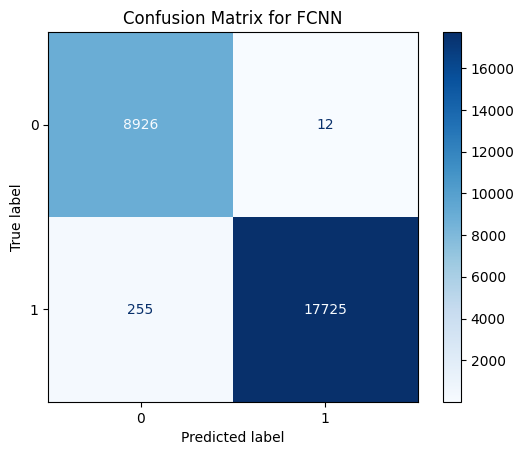

ROC-AUC Score: 0.9971237652238346


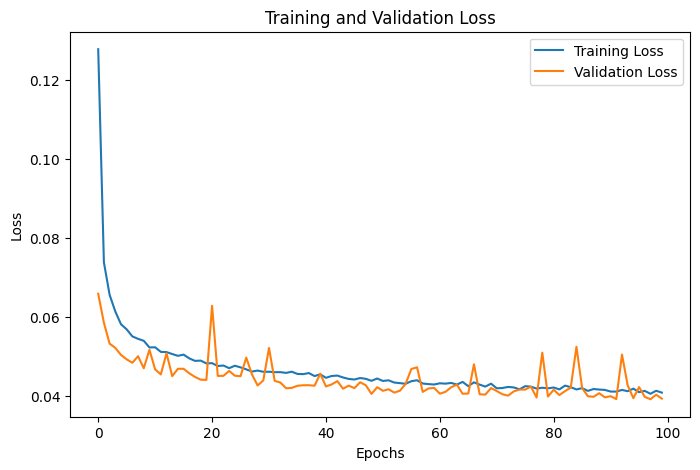

In [ ]:
# Tune hyperparameters dynamically by calling the function with different settings
fcnn_model_1, fcnn_history_1 = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],
    hidden_layers=[64, 32, 16],  # Adjusted hidden layers to 3 layers with fewer neurons
    activation='relu',
    dropout_rates=[0.2, 0.2, 0.1],  # Changed dropout rates
    optimizer='sgd',  # Using SGD instead of Adam
    epochs=100,  # Increased epochs for better convergence
    batch_size=16  # Smaller batch size
)

### 3. Second Hyperparameter Tuning

For the second hyperparameter tuning, fewer but larger hidden layers was experimented with, switching the activation function from ReLU to `tanh`. Additionally, RMSprop was used as the optimizer, the dropout rates was also increased to enhance regularization. This experiment aims to find whether a different activation function and a different optimization strategy yield better results.


Epoch 1/50
13459/13459 [==============================] - 15s 1ms/step - loss: 0.0851 - accuracy: 0.9776 - val_loss: 0.0638 - val_accuracy: 0.9837
Epoch 2/50
13459/13459 [==============================] - 14s 1ms/step - loss: 0.0765 - accuracy: 0.9810 - val_loss: 0.0703 - val_accuracy: 0.9823
Epoch 3/50
13459/13459 [==============================] - 14s 1ms/step - loss: 0.0736 - accuracy: 0.9822 - val_loss: 0.0655 - val_accuracy: 0.9845
Epoch 4/50
13459/13459 [==============================] - 14s 1ms/step - loss: 0.0708 - accuracy: 0.9831 - val_loss: 0.0790 - val_accuracy: 0.9839
Epoch 5/50
13459/13459 [==============================] - 14s 1ms/step - loss: 0.0704 - accuracy: 0.9835 - val_loss: 0.0573 - val_accuracy: 0.9851
Epoch 6/50
13459/13459 [==============================] - 14s 1ms/step - loss: 0.0707 - accuracy: 0.9837 - val_loss: 0.0612 - val_accuracy: 0.9855
Epoch 7/50
13459/13459 [==============================] - 14s 1ms/step - loss: 0.0695 - accuracy: 0.9838 - val_loss: 0

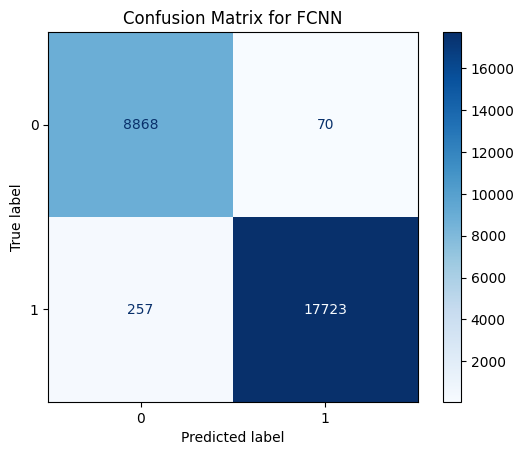

ROC-AUC Score: 0.9947819436379299


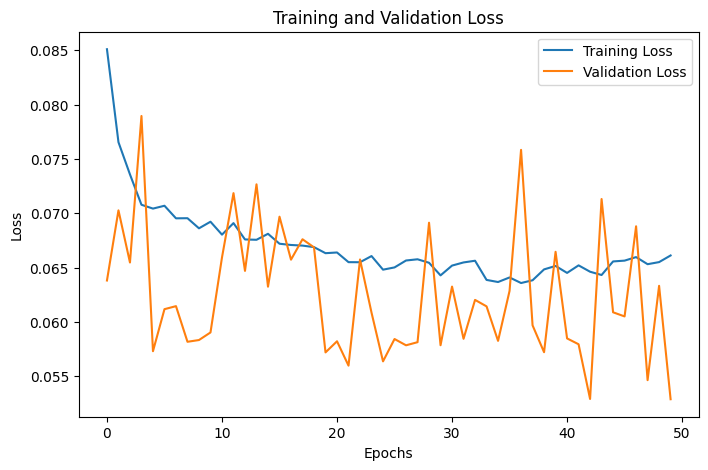

In [ ]:
# Second hyperparameter tuning: Fewer but larger hidden layers, different activation, and optimizer
fcnn_model_2, fcnn_history_2 = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],  # Number of input features
    hidden_layers=[256, 128],  # Two hidden layers with more neurons
    activation='tanh',  # Use tanh activation function
    dropout_rates=[0.4, 0.3],  # Increased dropout rates for regularization
    optimizer='rmsprop',  # Use RMSprop optimizer
    epochs=50,  # Train for 50 epochs
    batch_size=8  # Smaller batch size for better generalization
)

# Lung Segmented Analysis at Feature Level - Deep Learning

This section covers the development of a Fully Connected Neural Network (FCNN) for lung-segmented deep learning analysis. The process starts by using a baseline FCNN model for binary classification which was already built and applied to the full body data, followed by two sets of rigorous hyperparameter tuning to improve model performance. Each model is evaluated using metrics such as accuracy, ROC-AUC, and confusion matrix, along with visualizations for training loss and validation loss.

### 1: Baseline FCNN Model Initialization and Training

The baseline Fully Connected Neural Network (FCNN) is trained on the standardized lung-segmented training data. As earlier described, the model has two hidden layers and uses ReLU activation. The Adam optimizer is used to train the model, and the training performance is evaluated using the test set.

In [ ]:
# Load and Prepare the Data
combined_df = pd.read_csv('select_radiomics_features_labels.csv')  # Load the combined features and labels from a CSV file

# Separate the features and labels from the re-loaded combined DataFrame
features_df = combined_df.drop('label', axis=1)  # Drop the 'label' column to create a DataFrame with only feature columns
labels = combined_df['label']  # Extract the 'label' column as the target labels array

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_df, labels, test_size=0.2, random_state=42
)  # Use 20% of the data for testing, and set a random state for reproducibility
# Standardize the data

# Standardize the Data
scaler = StandardScaler()  # Initialize a StandardScaler to standardize the features

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)  # Scale the training features

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)  # Scale the testing features using the scaler fitted on the training data

Epoch 1/50
2158/2158 [==============================] - 6s 3ms/step - loss: 0.6325 - accuracy: 0.6711 - val_loss: 0.6185 - val_accuracy: 0.6791
Epoch 2/50
2158/2158 [==============================] - 4s 2ms/step - loss: 0.6221 - accuracy: 0.6754 - val_loss: 0.6120 - val_accuracy: 0.6870
Epoch 3/50
2158/2158 [==============================] - 4s 2ms/step - loss: 0.6185 - accuracy: 0.6777 - val_loss: 0.6087 - val_accuracy: 0.6859
Epoch 4/50
2158/2158 [==============================] - 3s 1ms/step - loss: 0.6158 - accuracy: 0.6788 - val_loss: 0.6077 - val_accuracy: 0.6871
Epoch 5/50
2158/2158 [==============================] - 3s 1ms/step - loss: 0.6133 - accuracy: 0.6794 - val_loss: 0.6050 - val_accuracy: 0.6888
Epoch 6/50
2158/2158 [==============================] - 3s 1ms/step - loss: 0.6118 - accuracy: 0.6821 - val_loss: 0.6034 - val_accuracy: 0.6887
Epoch 7/50
2158/2158 [==============================] - 3s 1ms/step - loss: 0.6110 - accuracy: 0.6819 - val_loss: 0.6006 - val_accuracy:

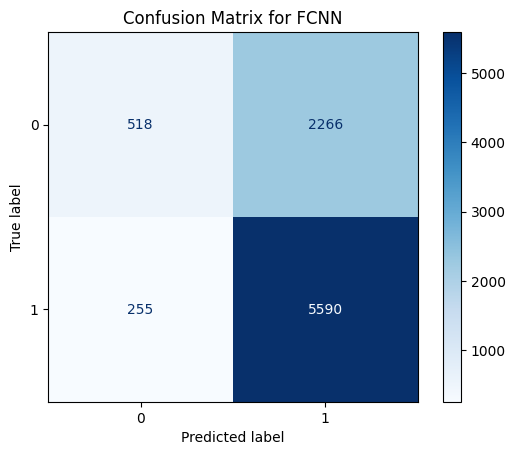

ROC-AUC Score: 0.6947102715750765


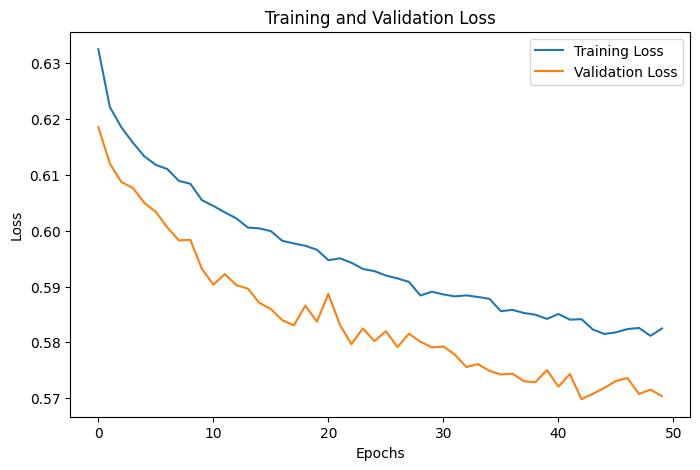

In [ ]:
# Train and evaluate the baseline FCNN model on the lung segmented data at feature level
fcnn_model, fcnn_history = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],  # Number of input features
    hidden_layers=[128, 64],  # Two hidden layers
    activation='relu',  # ReLU activation function for hidden layers
    dropout_rates=[0.3, 0.2],  # Dropout rates for regularization
    optimizer='adam',  # Adam optimizer
    epochs=50,  # Train for 50 epochs
    batch_size=16  # Batch size of 16
)

### 1st Hyper Tuning segment

As earlier described the baseline FCNN model is modified to include more hidden layers with adjusted dropout rates. The optimizer is switched to Stochastic Gradient Descent (SGD), and the number of epochs is increased to improve convergence and performance.

Epoch 1/100
2158/2158 [==============================] - 3s 1ms/step - loss: 0.6411 - accuracy: 0.6642 - val_loss: 0.6245 - val_accuracy: 0.6786
Epoch 2/100
2158/2158 [==============================] - 2s 1ms/step - loss: 0.6313 - accuracy: 0.6717 - val_loss: 0.6231 - val_accuracy: 0.6798
Epoch 3/100
2158/2158 [==============================] - 2s 1ms/step - loss: 0.6283 - accuracy: 0.6737 - val_loss: 0.6214 - val_accuracy: 0.6819
Epoch 4/100
2158/2158 [==============================] - 2s 1ms/step - loss: 0.6275 - accuracy: 0.6746 - val_loss: 0.6196 - val_accuracy: 0.6826
Epoch 5/100
2158/2158 [==============================] - 3s 1ms/step - loss: 0.6262 - accuracy: 0.6748 - val_loss: 0.6186 - val_accuracy: 0.6815
Epoch 6/100
2158/2158 [==============================] - 2s 1ms/step - loss: 0.6239 - accuracy: 0.6752 - val_loss: 0.6175 - val_accuracy: 0.6836
Epoch 7/100
2158/2158 [==============================] - 3s 1ms/step - loss: 0.6239 - accuracy: 0.6758 - val_loss: 0.6164 - val_ac

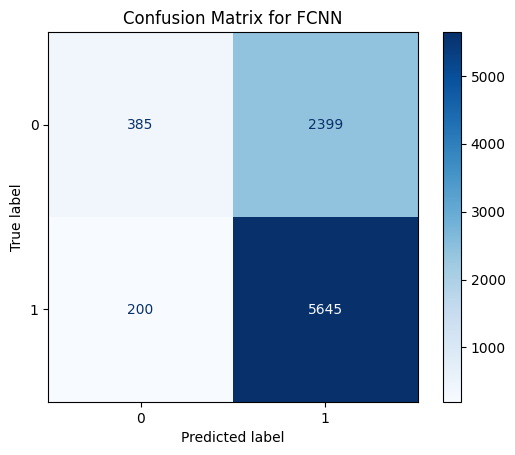

ROC-AUC Score: 0.6564629054698484


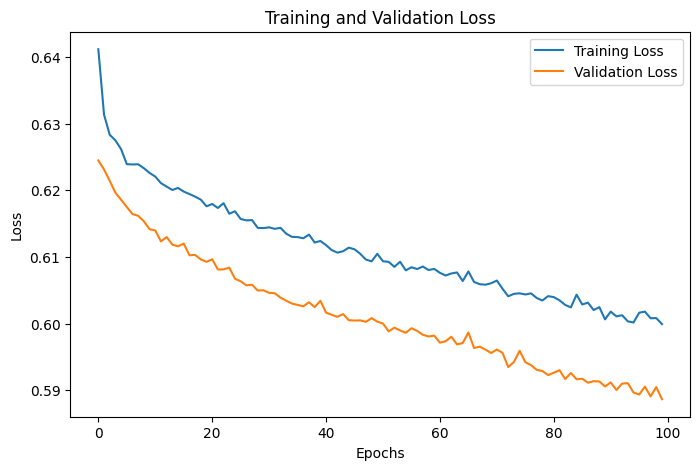

In [ ]:
fcnn_model_1, fcnn_history_1 = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],
    hidden_layers=[64, 32, 16],  # Adjusted hidden layers to 3 layers with fewer neurons
    activation='relu',
    dropout_rates=[0.2, 0.2, 0.1],  # Changed dropout rates
    optimizer='sgd',  # Using SGD instead of Adam
    epochs=100,  # Increased epochs for better convergence
    batch_size=16  # Smaller batch size
)

### 2nd Hyper Tuning Segment

Further tuning is performed by using larger hidden layers, tanh activation functions, and the RMSprop optimizer. This configuration is designed to test the effect of different activation functions and optimizers on model performance.

Epoch 1/50
4315/4315 [==============================] - 7s 2ms/step - loss: 0.6446 - accuracy: 0.6556 - val_loss: 0.6244 - val_accuracy: 0.6834
Epoch 2/50
4315/4315 [==============================] - 6s 1ms/step - loss: 0.6287 - accuracy: 0.6711 - val_loss: 0.6225 - val_accuracy: 0.6724
Epoch 3/50
4315/4315 [==============================] - 6s 1ms/step - loss: 0.6267 - accuracy: 0.6705 - val_loss: 0.6185 - val_accuracy: 0.6801
Epoch 4/50
4315/4315 [==============================] - 6s 1ms/step - loss: 0.6266 - accuracy: 0.6744 - val_loss: 0.6203 - val_accuracy: 0.6826
Epoch 5/50
4315/4315 [==============================] - 5s 1ms/step - loss: 0.6244 - accuracy: 0.6731 - val_loss: 0.6193 - val_accuracy: 0.6822
Epoch 6/50
4315/4315 [==============================] - 5s 1ms/step - loss: 0.6245 - accuracy: 0.6739 - val_loss: 0.6110 - val_accuracy: 0.6851
Epoch 7/50
4315/4315 [==============================] - 5s 1ms/step - loss: 0.6237 - accuracy: 0.6742 - val_loss: 0.6133 - val_accuracy:

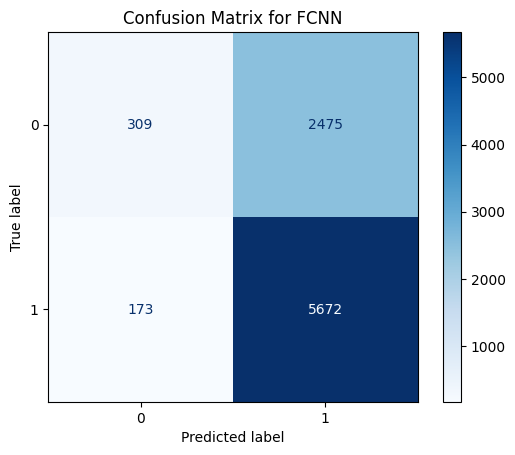

ROC-AUC Score: 0.6002418807704788


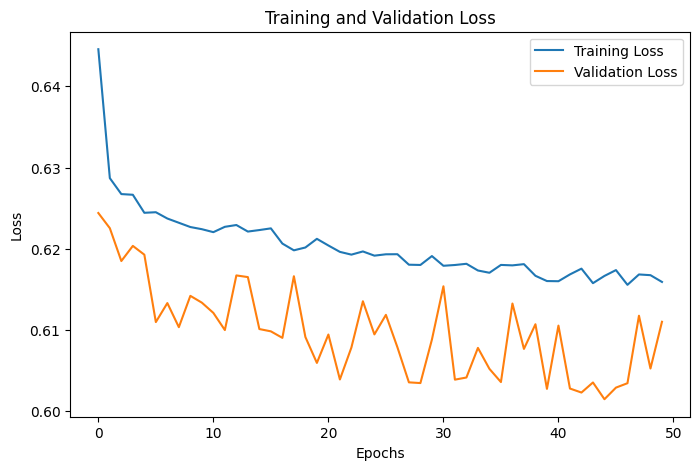

In [ ]:
# Second hyperparameter tuning: Fewer but larger hidden layers, different activation, and optimizer
fcnn_model_2, fcnn_history_2 = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],  # Number of input features
    hidden_layers=[256, 128],  # Two hidden layers with more neurons
    activation='tanh',  # Use tanh activation function
    dropout_rates=[0.4, 0.3],  # Increased dropout rates for regularization
    optimizer='rmsprop',  # Use RMSprop optimizer
    epochs=50,  # Train for 50 epochs
    batch_size=8  # Smaller batch size for better generalization
)

# Full-Body Patient-Level Feature Extraction, Aggregation

The following steps describe the patient-level workflow for Patient-Level Feature Extraction, Aggregation, before classifying PD-L1 expression levels  

1. **Flattening and Aggregating Patient-Level Features**: Extract, flatten, and aggregate features at the patient level using the mean of each feature across slices.
2. **Loading Patient Data from Directories**: Define paths to the data directories and load patient features from disk.
3. **Combining and Aggregating Positive and Negative Patient Features**: Aggregate and combine features for positive and negative patients.
4. **Combining and Preparing Patient-Level Data for Analysis**: Combine the features for both positive and negative patients, prepare the final dataset, and scale features.
5. **Feature Importance Analysis Using RandomForest**: Train a RandomForest model to evaluate feature importances and select the most relevant features.
6. **Creating and Saving the Final Patient-Level Dataset**: Combine selected features and labels, and save the final dataset for future use.


## Step 1: Flattening and Aggregating Patient-Level Features

Each patient's features are extracted and aggregated using the mean value of each feature across slices. This step creates a single feature vector per patient, representing the average radiomic characteristics of that patient’s lung-segmented slices.

In [ ]:
def flatten_ordered_dict(ordered_dict):
    """
    Flattens an OrderedDict to ensure all values are numeric.

    Args:
        ordered_dict (OrderedDict): Dictionary containing nested feature data with complex structures.

    Returns:
        dict: A flattened dictionary with only numeric values.

    Explanation:
    - This function iterates through each key-value pair in the OrderedDict.
    - It tries to convert each value to a float, skipping non-numeric values.
    - The resulting dictionary will contain only numeric values, making it easier to use in subsequent data processing steps.
    """
    flat_dict = {}  # Initialize an empty dictionary for storing numeric values
    for key, value in ordered_dict.items():
        try:
            # Convert the value to a float if possible
            flat_dict[key] = float(value)
        except (ValueError, TypeError):
            # If conversion fails (e.g., value is a string or non-numeric type), skip the value
            continue
    return flat_dict


def flatten_features(patient_data):
    """
    Flattens all features from patient data and returns a structured DataFrame.

    Args:
        patient_data (list): List of OrderedDicts, where each OrderedDict contains slice-level radiomic features for a patient.

    Returns:
        pd.DataFrame: A DataFrame containing flattened features for each slice of the patient.

    Explanation:
    - This function iterates through each feature set (OrderedDict) in the patient data.
    - It uses the `flatten_ordered_dict` function to flatten each OrderedDict.
    - All flattened feature sets are combined into a DataFrame for further aggregation.
    """
    flattened_features = []  # Initialize an empty list to hold flattened features
    for feature_set in patient_data:
        if isinstance(feature_set, OrderedDict):
            # Flatten each OrderedDict using the helper function `flatten_ordered_dict`
            flat_dict = flatten_ordered_dict(feature_set)
            flattened_features.append(flat_dict)  # Append the flattened dictionary to the list
    return pd.DataFrame(flattened_features)  # Convert the list of flattened dictionaries to a DataFrame


def aggregate_patient_features_mean_only(patient_data):
    """
    Aggregate features from multiple slices to create a single feature vector per patient using the mean.

    Args:
        patient_data (list): List of OrderedDicts, where each OrderedDict contains slice-level features for a patient.

    Returns:
        pd.Series: A single-row DataFrame (Series) containing mean-aggregated features for the patient.

    Explanation:
    - This function first flattens all slice-level features using `flatten_features`.
    - It then computes the mean of each feature across all slices, resulting in a single vector for the patient.
    - The mean-aggregated feature vector is returned as a single-row DataFrame, which can later be used for patient-level modeling.
    """
    # Flatten all features for a patient into a DataFrame
    patient_df = flatten_features(patient_data)

    # Compute the mean of each feature across all slices to create a single feature vector
    aggregated_features = patient_df.mean().to_frame().T  # Transpose the resulting Series into a DataFrame

    return aggregated_features.squeeze()  # Return as a single feature vector


def aggregate_all_patients_mean_only(patient_dict, positive_patient_ids):
    """
    Aggregate features for all patients using the mean of slice-level features.

    Args:
        patient_dict (dict): Dictionary containing patient IDs as keys and lists of OrderedDicts (slice-level features) as values.
        positive_patient_ids (set): Set of patient IDs corresponding to positive cases.

    Returns:
        pd.DataFrame: DataFrame containing mean-aggregated features for all patients.
        list: List of labels for each patient (1 for positive, 0 for negative).

    Explanation:
    - This function iterates through all patients in the provided dictionary.
    - For each patient, slice-level features are aggregated using the mean.
    - A label is assigned based on whether the patient is in the positive or negative dataset.
    - All aggregated patient-level features and corresponding labels are combined into a DataFrame and a list.
    """
    all_patient_features = []  # Initialize an empty list to hold aggregated features for all patients
    labels = []  # Initialize an empty list to hold labels (1 for positive, 0 for negative)

    for patient_id, patient_data in patient_dict.items():
        # Aggregate features for the current patient
        aggregated_features = aggregate_patient_features_mean_only(patient_data)
        aggregated_features['PatientID'] = patient_id  # Store the patient ID for reference
        all_patient_features.append(aggregated_features)  # Add the aggregated features to the list

        # Assign label based on whether the patient is in the positive set
        labels.append(1 if patient_id in positive_patient_ids else 0)

    # Combine all patient-level features into a single DataFrame
    features_df = pd.DataFrame(all_patient_features)

    return features_df, labels


## Step 2: Data Loading Functions

These functions are used to define paths to the directories containing patient data, load extracted features for both positive and negative patients, and manage intermediate processing results.

In [ ]:
# Define paths to directories containing patient data
base_directory = 'C:\\Anonymized PD-L1'  # Path to the base directory where patient data is stored
positive_dir = os.path.join(base_directory, 'PD-L1 Positive')  # Subdirectory for PD-L1 positive patients
negative_dir = os.path.join(base_directory, 'PD-L1 Negative')  # Subdirectory for PD-L1 negative patients

# Directory where intermediate results will be saved, this includes extracted features
output_directory = 'C:\\Anonymized PD-L1 Output'

# Log file to keep track of processed patients
log_file = 'processed_patients.log'  # This file records IDs of patients that have already been processed

## Step 3: Combining and Aggregating Positive and Negative Patient Features

Load and aggregate features for PD-L1 positive and negative patients, and combine them into a single dataset.

In [ ]:
# Load extracted features for PD-L1 positive patients
positive_data = load_features_from_output_dir(positive_dir, output_directory)

# Load extracted features for PD-L1 negative patients
negative_data = load_features_from_output_dir(negative_dir, output_directory)

Loading features for Patient 1 from C:\Anonymized PD-L1 Output\Patient 1_features.npy
Loaded 399 features for Patient 1
Loading features for Patient 10 from C:\Anonymized PD-L1 Output\Patient 10_features.npy
Loaded 472 features for Patient 10
Loading features for Patient 100 from C:\Anonymized PD-L1 Output\Patient 100_features.npy
Loaded 415 features for Patient 100
Loading features for Patient 101 from C:\Anonymized PD-L1 Output\Patient 101_features.npy
Loaded 425 features for Patient 101
Loading features for Patient 102 from C:\Anonymized PD-L1 Output\Patient 102_features.npy
Loaded 403 features for Patient 102
Loading features for Patient 103 from C:\Anonymized PD-L1 Output\Patient 103_features.npy
Loaded 478 features for Patient 103
Loading features for Patient 104 from C:\Anonymized PD-L1 Output\Patient 104_features.npy
Loaded 433 features for Patient 104
Loading features for Patient 105 from C:\Anonymized PD-L1 Output\Patient 105_features.npy
Loaded 452 features for Patient 105
L

In [ ]:
# Aggregate features at the patient level
positive_patient_ids = positive_data.keys()  # Get the list of positive patient IDs
positive_features_df, positive_labels = aggregate_all_patients_mean_only(positive_data, positive_patient_ids)
negative_features_df, negative_labels = aggregate_all_patients_mean_only(negative_data, positive_patient_ids)

# Combine positive and negative features into a single DataFrame
features_df = pd.concat([positive_features_df, negative_features_df], ignore_index=True)
labels = positive_labels + negative_labels  # Combine labels for positive and negative patients

In [ ]:
features_df.tail()

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,PatientID
303,0.057876,0.0,1.0,15171.917782,5.313576,1.0,1.0,15171.917782,-3.203427e-16,0.0,...,0.016507,1.538414,0.001029,2.374377e+07,0.0,1000000.0,0.0,0.0,0.0,Patient 307
304,0.056120,0.0,1.0,14711.505882,9.830588,1.0,1.0,14711.505882,-3.203427e-16,0.0,...,0.032327,2.753501,0.001001,1.775880e+07,0.0,1000000.0,0.0,0.0,0.0,Patient 308
305,0.065801,0.0,1.0,17249.238683,5.802469,1.0,1.0,17249.238683,-3.203427e-16,0.0,...,0.032148,2.127483,0.000389,4.119974e+07,0.0,1000000.0,0.0,0.0,0.0,Patient 309
306,0.043319,0.0,1.0,11355.938326,2.997797,1.0,1.0,11355.938326,-3.203427e-16,0.0,...,0.012180,1.025261,0.000380,6.483302e+06,0.0,1000000.0,0.0,0.0,0.0,Patient 310
307,0.044569,0.0,1.0,11683.600402,3.078313,1.0,1.0,11683.600402,-3.203427e-16,0.0,...,0.010036,1.031820,0.002400,2.567251e+07,0.0,1000000.0,0.0,0.0,0.0,Patient 311


## Step 4: Feature Scaling, Train-Test Splitting, and Feature Selection

The patient-level features are scaled, and the data is split into training and testing sets. A RandomForest model is then trained on the scaled features to compute feature importances, and the most important features are selected based on a predefined threshold.

In [ ]:
# Remove PatientID column to create the feature DataFrame for modeling
patient_features_df = features_df.drop('PatientID', axis=1)

In [ ]:
# Print total number of features before selection
print(f"Total number of features before selection: {patient_features_df.shape[1]}")

# Handle missing values by filling with zeros
patient_features_df.fillna(0, inplace=True)

# Standardize the features
scaler = StandardScaler()
patient_features_scaled = scaler.fit_transform(patient_features_df)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(patient_features_scaled, labels, test_size=0.2, random_state=42)

# Train RandomForest Classifier to compute feature importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Get Feature Importances
feature_importances = rf_classifier.feature_importances_

# Select Features Based on Importance
importance_threshold = 0.01  # Threshold for feature selection
selected_features = np.where(feature_importances > importance_threshold)[0]
selected_feature_names = patient_features_df.columns[selected_features]

# Output selected features
print(f"Number of selected features: {len(selected_features)}")
print(f"Selected feature indices: {selected_features}")
print(f"Selected feature names: {list(selected_feature_names)}")

Total number of features before selection: 98
Number of selected features: 25
Selected feature indices: [ 3  7 20 47 48 49 50 51 54 55 56 58 59 60 61 65 66 67 71 72 73 81 82 83
 92]
Selected feature names: ['diagnostics_Mask-original_VoxelNum', 'original_firstorder_Energy', 'original_firstorder_TotalEnergy', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_RunLeng

## Step 5: Save the Selected Features

Save the selected patient-level features along with their labels into a CSV file for future use and analysis.

In [ ]:
# Create a new DataFrame with only the selected features
selected_patient_features_df = patient_features_df[selected_feature_names]
selected_patient_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 25 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Mask-original_VoxelNum                  308 non-null    float64
 1   original_firstorder_Energy                          308 non-null    float64
 2   original_firstorder_TotalEnergy                     308 non-null    float64
 3   original_gldm_DependenceEntropy                     308 non-null    float64
 4   original_gldm_DependenceNonUniformity               308 non-null    float64
 5   original_gldm_DependenceNonUniformityNormalized     308 non-null    float64
 6   original_gldm_DependenceVariance                    308 non-null    float64
 7   original_gldm_GrayLevelNonUniformity                308 non-null    float64
 8   original_gldm_LargeDependenceEmphasis               308 non-null    float64
 9  

In [ ]:
# Combine selected features with labels
labels_df = pd.DataFrame(labels, columns=['label'])
selected_patient_features_df_reset = selected_patient_features_df.reset_index(drop=True)
labels_df_reset = labels_df.reset_index(drop=True)
combined_df = pd.concat([selected_patient_features_df_reset, labels_df_reset], axis=1)

# Save to a CSV file
combined_df.to_csv('New_Full_Patient_Level_radiomics_features_labels.csv', index=False)

# Full Body Analysis at Patient Level - Ensemble Models

## Data Loading and Preparation

The patient-level radiomics features and labels are reloaded from the CSV file into a pandas DataFrame. The labels are then separated from the features to prepare them for further data processing and model training.


In [ ]:
combined_df = pd.read_csv('New_Full_Patient_Level_radiomics_features_labels.csv')

In [ ]:
# Step 1: Load the combined patient-level features and labels from a CSV file
combined_df = pd.read_csv('New_Full_Patient_Level_radiomics_features_labels.csv')  # Load the data into a DataFrame

# Separate features and labels
features_df = combined_df.drop('label', axis=1)  # Drop the 'label' column to create the features DataFrame
labels = combined_df['label']  # Extract the 'label' column as the labels array

In [ ]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 25 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Mask-original_VoxelNum                  308 non-null    float64
 1   original_firstorder_Energy                          308 non-null    float64
 2   original_firstorder_TotalEnergy                     308 non-null    float64
 3   original_gldm_DependenceEntropy                     308 non-null    float64
 4   original_gldm_DependenceNonUniformity               308 non-null    float64
 5   original_gldm_DependenceNonUniformityNormalized     308 non-null    float64
 6   original_gldm_DependenceVariance                    308 non-null    float64
 7   original_gldm_GrayLevelNonUniformity                308 non-null    float64
 8   original_gldm_LargeDependenceEmphasis               308 non-null    float64
 9  

## Data Scaling, Train-Test Splitting, and SMOTE Resampling

The data is divided into training and testing sets using an 80-20 split. SMOTE is applied to the training set to handle class imbalance by generating synthetic samples for the minority class. This step ensures a balanced dataset for model training, which improves model robustness and performance.

In [ ]:
# Step 2: Train-Test Split and SMOTE Resampling

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

# Initialize SMOTE with a fixed random state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to balance the classes
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Random Forest Analysis

This section provides a detailed analysis of the Random Forest model applied to full body data at patient-level. A baseline model was initialized, then proceed to cross-validation, regularization, and hyperparameter tuning to identify the best parameters for the Random Forest model. The model's performance is evaluated on both resampled and non-resampled data using metrics such as accuracy, ROC-AUC, and confusion matrix.

### 1. Baseline Model Initialization and Training
A baseline RandomForestClassifieris initialized with default parameters and train it on the resampled training data. The train_model function is used for training and evaluation, which prints the performance metrics and generates visualisations such as the confusion matrix and log loss plots.

Accuracy: 0.9838709677419355
ROC-AUC: 0.9981060606060606
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.98      0.99        44

    accuracy                           0.98        62
   macro avg       0.97      0.99      0.98        62
weighted avg       0.98      0.98      0.98        62



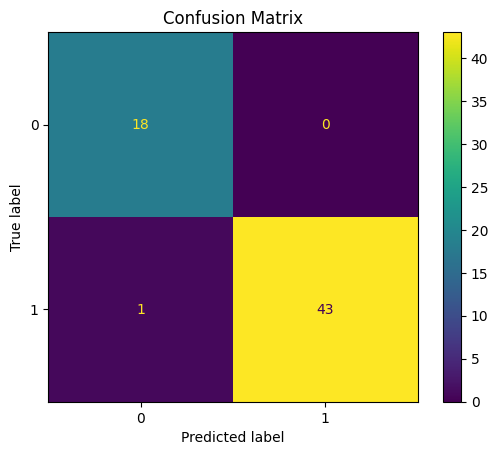

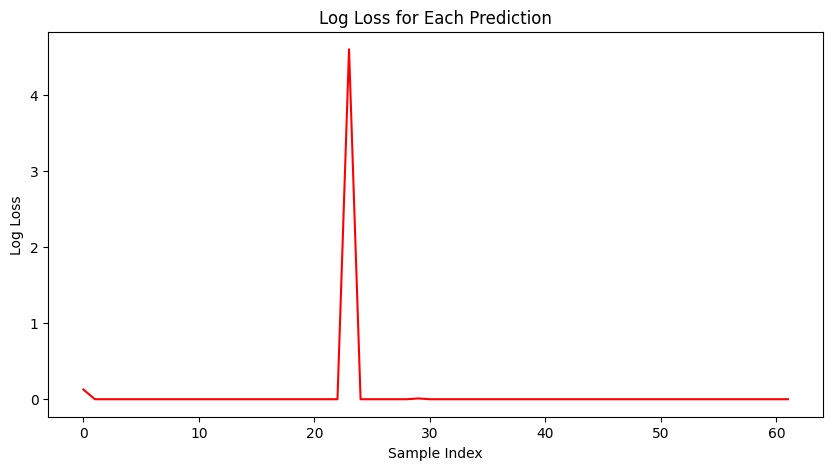

In [ ]:
# Initialize the baseline RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the baseline model using the resampled training data
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, rf_classifier)

### 2. Cross-Validation on Pre-SMOTEd Data

The random `cross_validate_pre_smoted_data` function performs cross-validation on the Random Forest model using the pre-SMOTEd training data. The random forest model was evaluated with Cross-validation using the previously defined  `cross_validate_pre_smoted_data` function across multiple folds of the data.


Cross-Validation Accuracy Scores: [0.98484848 0.98461538 1.         0.98461538 1.        ]
Mean Accuracy: 0.9908


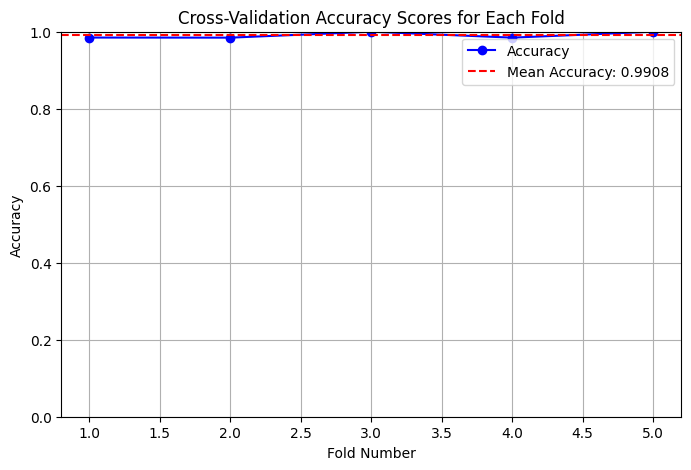

array([0.98484848, 0.98461538, 1.        , 0.98461538, 1.        ])

In [ ]:
# Cross-validate the Random Forest model using pre-SMOTEd training data
cross_validate_pre_smoted_data(rf_classifier, X_train, y_train, X_test, y_test, cv=5)

### 3. Regularization and Parameter Adjustment

As earlier done, the Random Forest model parameters were adjusted to control overfitting and improve performance. Regularization techniques include setting constraints on tree depth (max_depth), minimum samples required to split a node (min_samples_split), and minimum samples required at a leaf node (min_samples_leaf).

Accuracy: 0.9838709677419355
ROC-AUC: 0.9823232323232323
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.98      0.99        44

    accuracy                           0.98        62
   macro avg       0.97      0.99      0.98        62
weighted avg       0.98      0.98      0.98        62



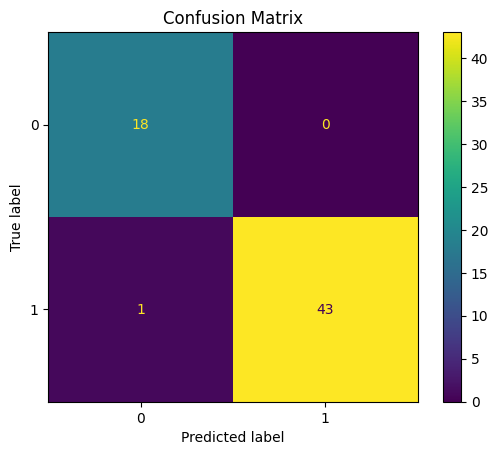

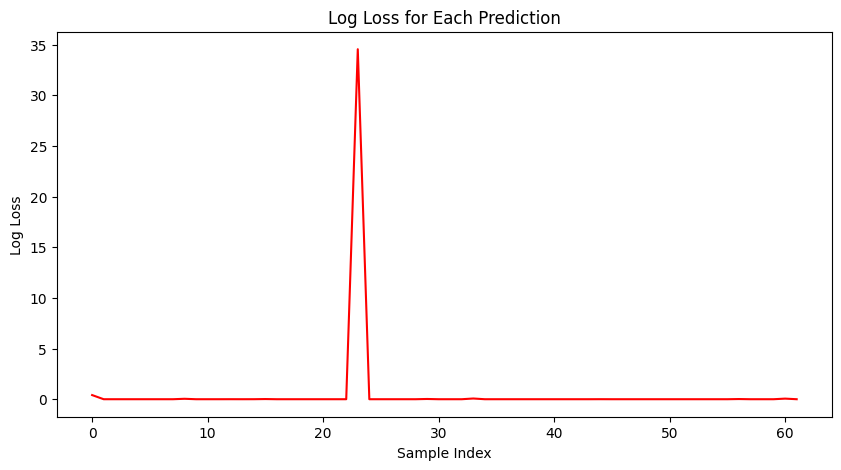

In [ ]:
# Adjust parameters for regularization
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Control tree depth
    min_samples_split=5,  # Minimum samples required to split a node
    min_samples_leaf=4,  # Minimum samples required at a leaf node
    max_features='sqrt',  # Use sqrt(features) at each split
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

# Train the model using the resampled training data with new parameters
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, rf_classifier)

### 4. Hyperparameter Tuning with Random Search

The perform_random_search function which was previously used in the feature-level analysis to perform hyperparameter tuning using Randomized Search was also used on the patient-level.

In [ ]:
# Step 1: Define the parameter grid for RandomForest
param_dist_rf = {
    'n_estimators': randint(100, 500),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of each tree
    'min_samples_split': randint(2, 10),  # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 5),  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider at each split
}

In [ ]:
# Step 2: Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Step 3: Perform Random Search for hyperparameter tuning
best_rf_model, best_rf_params, best_rf_score = perform_random_search(
    classifier=rf_classifier,
    param_distributions=param_dist_rf,
    X_train=X_train_smote,
    y_train=y_train_smote
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 171}
Best Cross-Validation Score: 0.9907692307692308


Accuracy: 0.9838709677419355
ROC-AUC: 0.9917929292929293
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.98      0.99        44

    accuracy                           0.98        62
   macro avg       0.97      0.99      0.98        62
weighted avg       0.98      0.98      0.98        62



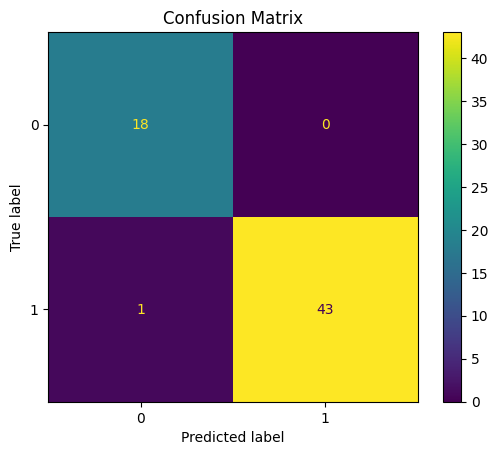

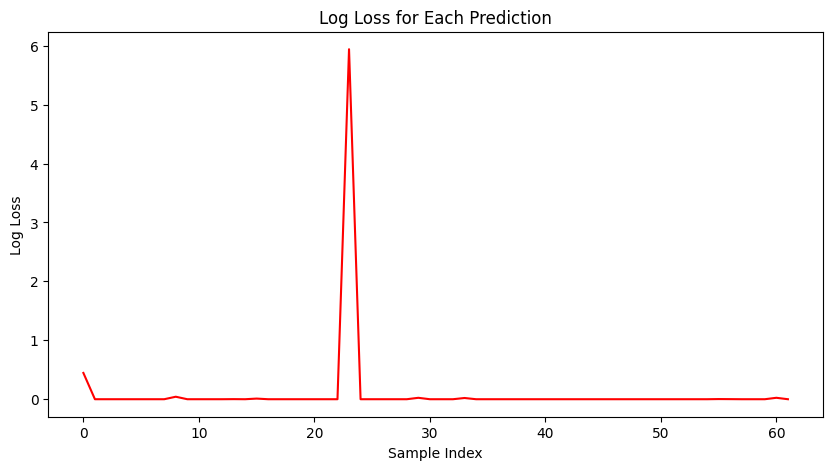

In [ ]:
# Step 4: Train and Evaluate the Best Model
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, best_rf_model)

## XGBoost Model Analysis

This section provides a detailed analysis of the XGBoost model applied to full-body data at the patient level.

C:\Users\752306\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9838709677419355
ROC-AUC: 0.985479797979798
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.98      0.99        44

    accuracy                           0.98        62
   macro avg       0.97      0.99      0.98        62
weighted avg       0.98      0.98      0.98        62



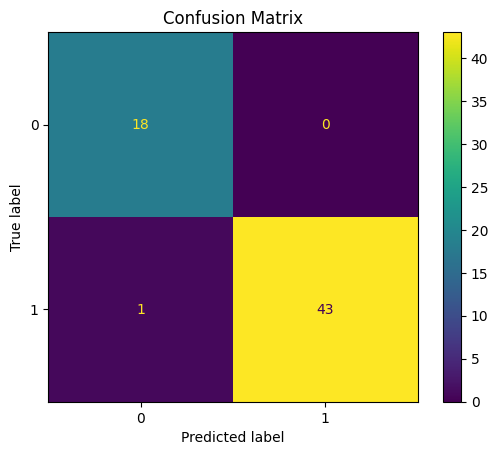

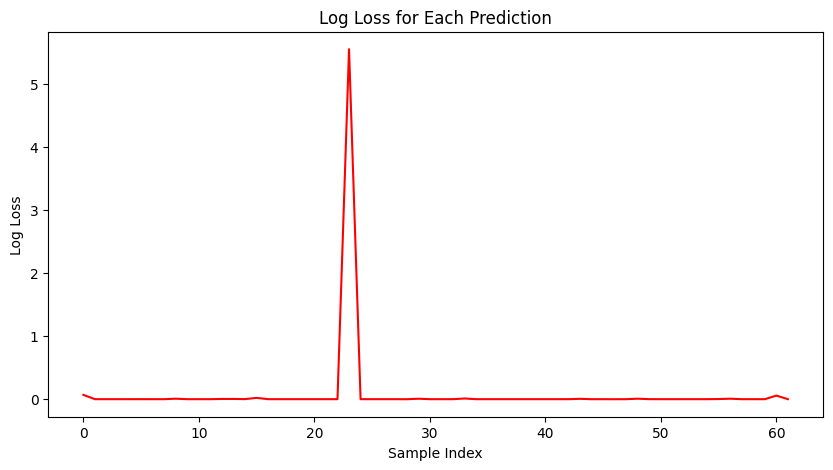

In [ ]:
# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model using the XGBoost classifier
trained_xgb = train_model(X_train, X_test, y_train, y_test, xgb_classifier)

### 2. Hyperparameter Tuning with Random Search

To optimize the performance of the XGBoost model, Random Search for hyperparameter tuning was used. The `perform_random_search` function explores a defined search space of hyperparameters and identifies the best combination that maximizes the model's performance.

In [ ]:

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [3, 5, 7, 9, 11],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of features used per tree
    'min_child_weight': [1, 3, 5, 7],  # Minimum sum of weights for child nodes
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1],  # L2 regularization
}

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Use the perform_random_search function
best_xgb_model, best_xgb_params, best_xgb_score = perform_random_search(
    classifier=xgb_classifier,
    param_distributions=param_grid_xgb,
    X_train=X_train_smote,  # training features after SMOTE
    y_train=y_train_smote,  # training labels after SMOTE
    cv=5,
    n_iter=50,  # Number of iterations
    scoring='accuracy'  # Scoring metric
)

# Output the best model details
print("Best XGBoost Model:", best_xgb_model)
print("Best Parameters for XGBoost:", best_xgb_params)
print("Best Score for XGBoost:", best_xgb_score)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\752306\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best Cross-Validation Score: 0.9907692307692308
Best XGBoost Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=

C:\Users\752306\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9838709677419355
ROC-AUC: 0.9873737373737373
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.98      0.99        44

    accuracy                           0.98        62
   macro avg       0.97      0.99      0.98        62
weighted avg       0.98      0.98      0.98        62



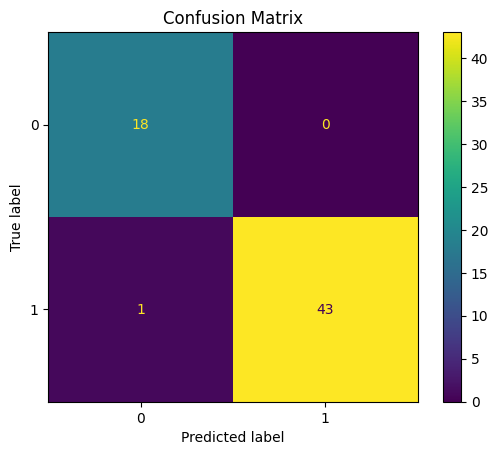

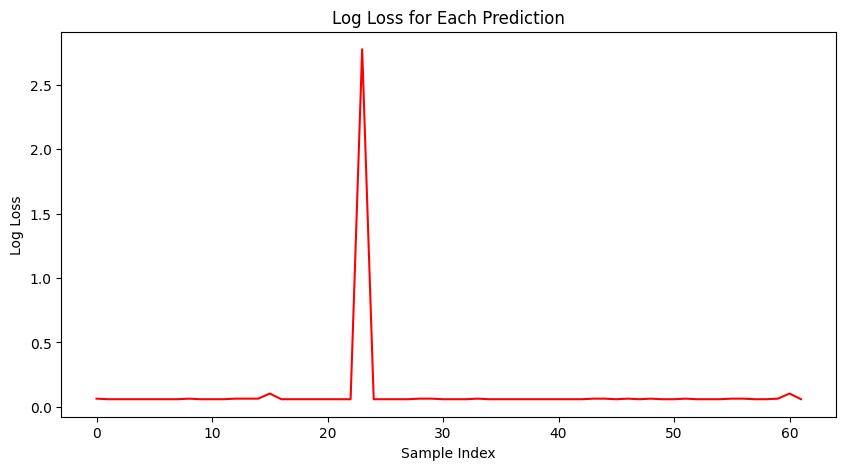

In [ ]:
# For XGBoost, use the best model obtained from random search
trained_xgb = train_model(X_train_smote, X_test, y_train_smote, y_test, best_xgb_model)

# Lung-Segmented Patient-Level Feature Extraction, Aggregation

The workflow covers the following steps:

1. **Loading Lung-Segmented Patient Data from Directories**: Define paths to the directories containing lung-segmented data and load patient features from disk.
2. **Combining and Aggregating Positive and Negative Patient Features**: Aggregate features for positive and negative patients separately and combine them into a single dataset.
3. **Combining and Preparing Lung-Segmented Patient-Level Data for Analysis**: Prepare the final dataset by combining the features for positive and negative patients, scale the features, and assign labels.
4. **Feature Importance Analysis Using RandomForest**: Train a RandomForest model to compute feature importances and select the most relevant features for classification.
5. **Creating and Saving the Final Lung-Segmented Patient-Level Dataset**: Combine the selected features and labels, and save the final dataset for future use and analysis.


## Step 1: Loading Lung-Segmented Patient Data from Directories

Define paths to directories containing lung-segmented data for positive and negative patients, and load the radiomic features from disk.


In [ ]:
# Define paths to directories containing patient data for lung-segmented patients
base_directory = 'C:\\Anonymized PD-L1'  # Path to the base directory where patient data is stored
positive_dir = os.path.join(base_directory, 'PD-L1 Positive')  # Subdirectory for PD-L1 positive patients
negative_dir = os.path.join(base_directory, 'PD-L1 Negative')  # Subdirectory for PD-L1 negative patients

# Directory where intermediate results will be saved, this includes extracted features
output_directory = 'C:\\Anonymized PD-L1 Output1'  # Specify the directory to save intermediate results

# Log file to keep track of processed patients
log_file = 'processed_patients.log1'  # This file records IDs of patients that have already been processed

## Step 2: Loading Lung-Segmented Patient-Level Features

Load extracted radiomic features for positive and negative lung-segmented patients from the specified directories. These features will be used for aggregation and analysis.


In [ ]:
# Load extracted features for PD-L1 positive patients
positive_data = load_features_from_output_dir(positive_dir, output_directory)

# Load extracted features for PD-L1 negative patients
negative_data = load_features_from_output_dir(negative_dir, output_directory)

Loading features for Patient 1 from C:\Anonymized PD-L1 Output1\Patient 1_features.npy
Loaded 141 features for Patient 1
Loading features for Patient 10 from C:\Anonymized PD-L1 Output1\Patient 10_features.npy
Loaded 141 features for Patient 10
Loading features for Patient 100 from C:\Anonymized PD-L1 Output1\Patient 100_features.npy
Loaded 141 features for Patient 100
Loading features for Patient 101 from C:\Anonymized PD-L1 Output1\Patient 101_features.npy
Loaded 141 features for Patient 101
Loading features for Patient 102 from C:\Anonymized PD-L1 Output1\Patient 102_features.npy
Loaded 141 features for Patient 102
Loading features for Patient 103 from C:\Anonymized PD-L1 Output1\Patient 103_features.npy
Loaded 141 features for Patient 103
Loading features for Patient 104 from C:\Anonymized PD-L1 Output1\Patient 104_features.npy
Loaded 141 features for Patient 104
Loading features for Patient 105 from C:\Anonymized PD-L1 Output1\Patient 105_features.npy
Loaded 141 features for Patie

## Step 3: Combining and Aggregating Positive and Negative Patient Features

Aggregate the features for positive and negative lung-segmented patients using the mean of each feature across slices. Combine the features into a single DataFrame and assign appropriate labels.

In [ ]:
# Aggregate features for positive and negative patients
positive_patient_ids = positive_data.keys()  # Get patient IDs for positive patients
positive_features_df, positive_labels = aggregate_all_patients_mean_only(positive_data, positive_patient_ids)
negative_features_df, negative_labels = aggregate_all_patients_mean_only(negative_data, positive_patient_ids)

# Combine positive and negative features into a single DataFrame
features_df = pd.concat([positive_features_df, negative_features_df], ignore_index=True)  # Combine the DataFrames
labels = positive_labels + negative_labels  # Combine positive and negative labels

# Remove 'PatientID' column to create the feature DataFrame for modeling
patient_features_df = features_df.drop('PatientID', axis=1)  # Drop 'PatientID' column for further analysis

# Display the structure and details of the combined DataFrame
patient_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 98 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Image-original_Mean                     307 non-null    float64
 1   diagnostics_Image-original_Minimum                  307 non-null    float64
 2   diagnostics_Image-original_Maximum                  307 non-null    float64
 3   diagnostics_Mask-original_VoxelNum                  307 non-null    float64
 4   diagnostics_Mask-original_VolumeNum                 307 non-null    float64
 5   original_firstorder_10Percentile                    307 non-null    float64
 6   original_firstorder_90Percentile                    307 non-null    float64
 7   original_firstorder_Energy                          307 non-null    float64
 8   original_firstorder_Entropy                         307 non-null    float64
 9  

## Step 4: Feature Importance Analysis Using RandomForest

Handle missing values, scale the features, and split the data into training and test sets. Train a RandomForest model on the training set to compute feature importances and select the most important features based on a predefined threshold.

In [ ]:
# Print total number of features before selection
print(f"Total number of features before selection: {patient_features_df.shape[1]}")

# Handle missing values
patient_features_df.fillna(0, inplace=True)  # Replace missing values with zeros

# Scale the features using StandardScaler
scaler = StandardScaler()
patient_features_scaled = scaler.fit_transform(patient_features_df)

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(patient_features_scaled, labels, test_size=0.2, random_state=42)

# Train RandomForest Classifier to compute feature importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize RandomForest model
rf_classifier.fit(X_train, y_train)  # Train the model on training data

# Get Feature Importances
feature_importances = rf_classifier.feature_importances_

# Select Features Based on Importance
importance_threshold = 0.01  # Define a threshold for feature selection
selected_features = np.where(feature_importances > importance_threshold)[0]  # Select features based on threshold
selected_feature_names = patient_features_df.columns[selected_features]  # Get names of selected features

# Output selected features
print(f"Number of selected features: {len(selected_features)}")
print(f"Selected feature indices: {selected_features}")
print(f"Selected feature names: {list(selected_feature_names)}")


Total number of features before selection: 98
Number of selected features: 40
Selected feature indices: [ 0  3  4  7 20 47 48 49 50 51 54 55 56 58 59 60 61 65 66 67 69 70 71 72
 73 74 75 76 77 81 82 83 85 86 87 88 89 90 91 92]
Selected feature names: ['diagnostics_Image-original_Mean', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'original_firstorder_Energy', 'original_firstorder_TotalEnergy', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_LongRunEmphasis

## Step 5: Creating and Saving the Final Lung-Segmented Patient-Level Dataset

Creating a new DataFrame with only the selected features, combine the features with their corresponding labels, and save the final dataset for future use and analysis.


In [ ]:
# Create a new DataFrame containing only the selected features
selected_patient_features_df = patient_features_df[selected_feature_names]
selected_patient_features_df.info()  # Display the structure and details of the new DataFrame


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 40 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Image-original_Mean                     308 non-null    float64
 1   diagnostics_Mask-original_VoxelNum                  308 non-null    float64
 2   diagnostics_Mask-original_VolumeNum                 308 non-null    float64
 3   original_firstorder_Energy                          308 non-null    float64
 4   original_firstorder_TotalEnergy                     308 non-null    float64
 5   original_gldm_DependenceEntropy                     308 non-null    float64
 6   original_gldm_DependenceNonUniformity               308 non-null    float64
 7   original_gldm_DependenceNonUniformityNormalized     308 non-null    float64
 8   original_gldm_DependenceVariance                    308 non-null    float64
 9  

In [ ]:
# Create a DataFrame from the labels array
labels_df = pd.DataFrame(labels, columns=['label'])

# Combine the features and labels into a single DataFrame along the columns
combined_df = pd.concat([selected_patient_features_df, labels_df], axis=1)

# Save the combined DataFrame to a CSV file for future use
combined_df.to_csv('New_Segmented_Patient_Level_radiomics_features_labels.csv', index=False)
print("Combined features and labels saved to 'New_Segmented_Patient_Level_radiomics_features_labels.csv'")

# Display the structure and information of the combined DataFrame
combined_df.info()

Combined features and labels saved to 'segmented_patient_radiomics_features_labels.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 41 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Image-original_Mean                     308 non-null    float64
 1   diagnostics_Mask-original_VoxelNum                  308 non-null    float64
 2   diagnostics_Mask-original_VolumeNum                 308 non-null    float64
 3   original_firstorder_Energy                          308 non-null    float64
 4   original_firstorder_TotalEnergy                     308 non-null    float64
 5   original_gldm_DependenceEntropy                     308 non-null    float64
 6   original_gldm_DependenceNonUniformity               308 non-null    float64
 7   original_gldm_DependenceNonUniformityNormalized     308 non-null    float

# Lung-Segmented Analysis at Patient-Level - Ensemble Models

## Data Loading and Preparation

The lung-segmented patient-level radiomics features and labels are reloaded from the CSV file into a pandas DataFrame. The labels are then separated from the features to prepare them for further data processing and model training.


In [ ]:
# Load the combined patient-level features and labels from a CSV file
combined_df = pd.read_csv('New_Segmented_Patient_Level_radiomics_features_labels.csv')  # Load the data into a DataFrame

# Step 2: Separate features and labels
features_df = combined_df.drop('label', axis=1)  # Drop the 'label' column to create the features DataFrame
labels = combined_df['label']  # Extract the 'label' column as the labels array

# Display the structure and information of the features DataFrame
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 40 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   diagnostics_Image-original_Mean                     308 non-null    float64
 1   diagnostics_Mask-original_VoxelNum                  308 non-null    float64
 2   diagnostics_Mask-original_VolumeNum                 308 non-null    float64
 3   original_firstorder_Energy                          308 non-null    float64
 4   original_firstorder_TotalEnergy                     308 non-null    float64
 5   original_gldm_DependenceEntropy                     308 non-null    float64
 6   original_gldm_DependenceNonUniformity               308 non-null    float64
 7   original_gldm_DependenceNonUniformityNormalized     308 non-null    float64
 8   original_gldm_DependenceVariance                    308 non-null    float64
 9  

## Data Scaling, Train-Test Splitting, and SMOTE Resampling

The data is divided into training and testing sets using an 80-20 split. SMOTE is applied to the training set to handle class imbalance by generating synthetic samples for the minority class. This step ensures a balanced dataset for model training, which improves model robustness and performance.


In [ ]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

# Initialize SMOTE with a fixed random state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to balance the classes
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Random Forest Classification for the Lung Segmented Data at Patient Level

This section provides a detailed analysis of the Random Forest model applied to lung-segmented data at patient level. A baseline model was initialized, then proceed to cross-validation, regularization, and hyperparameter tuning to identify the best parameters for the Random Forest model. The model's performance is evaluated on both resampled and non-resampled data using metrics such as accuracy, ROC-AUC, and confusion matrix.

### 1. Baseline Model Initialization and Training
A baseline RandomForestClassifier is initialized with default parameters and train it on the resampled training data. The train_model function is used for training and evaluation, which prints the performance metrics and generates visualisations such as the confusion matrix and log loss plots.

Accuracy: 0.5161290322580645
ROC-AUC: 0.4747474747474748
              precision    recall  f1-score   support

           0       0.20      0.22      0.21        18
           1       0.67      0.64      0.65        44

    accuracy                           0.52        62
   macro avg       0.43      0.43      0.43        62
weighted avg       0.53      0.52      0.52        62



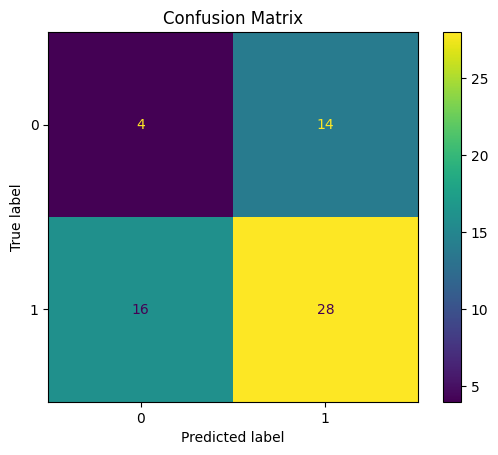

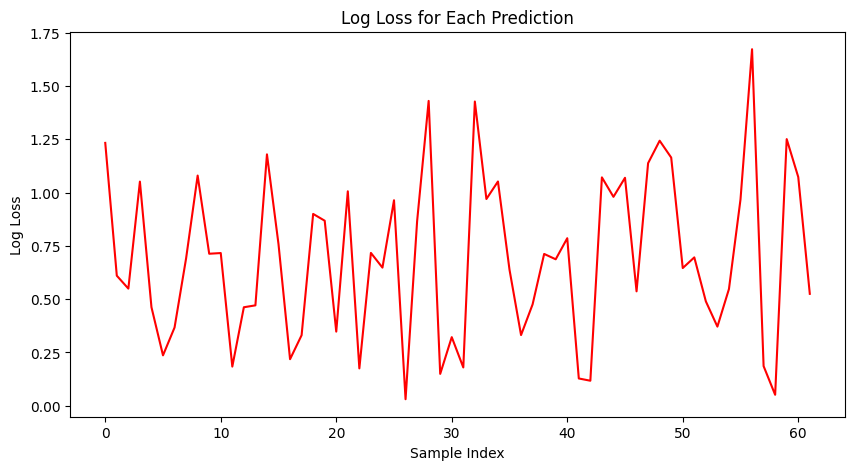

In [ ]:
# Initialize the baseline RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the baseline model using the resampled training data
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, rf_classifier)

### 2. Cross-Validation on Pre-SMOTEd Data

The random `cross_validate_pre_smoted_data` function performs cross-validation on the Random Forest model using the pre-SMOTEd training data. The random forest model was evaluated with Cross-validation using the previously defined  `cross_validate_pre_smoted_data` function across multiple folds of the data.


Cross-Validation Accuracy Scores: [0.65151515 0.66153846 0.61538462 0.69230769 0.61538462]
Mean Accuracy: 0.6472


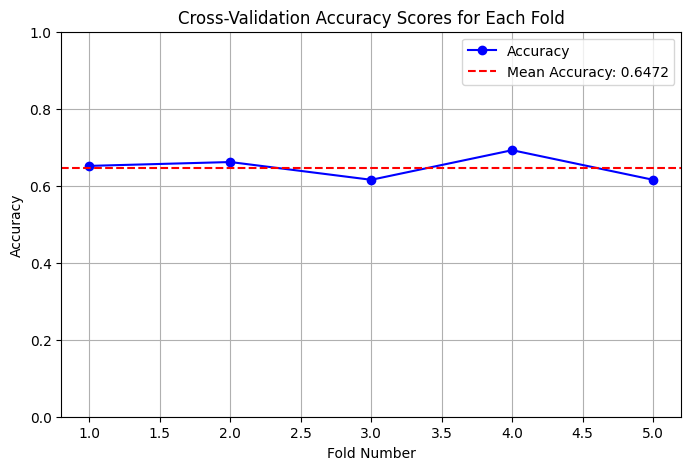

array([0.65151515, 0.66153846, 0.61538462, 0.69230769, 0.61538462])

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced'
)

cross_validate_pre_smoted_data(rf_model, X_train_smote, y_train_smote, X_test, y_test, cv=5)

### 3. Regularization and Parameter Adjustment

As earlier done, the Random Forest model parameters were adjusted to control overfitting and improve performance. Regularization techniques include setting constraints on tree depth (max_depth), minimum samples required to split a node (min_samples_split), and minimum samples required at a leaf node (min_samples_leaf).

Accuracy: 0.5483870967741935
ROC-AUC: 0.49747474747474746
              precision    recall  f1-score   support

           0       0.27      0.33      0.30        18
           1       0.70      0.64      0.67        44

    accuracy                           0.55        62
   macro avg       0.49      0.48      0.48        62
weighted avg       0.58      0.55      0.56        62



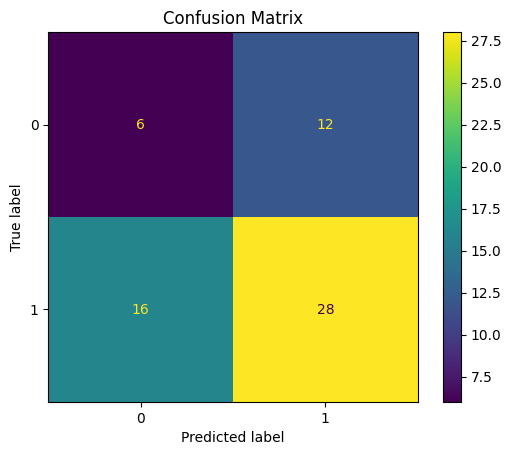

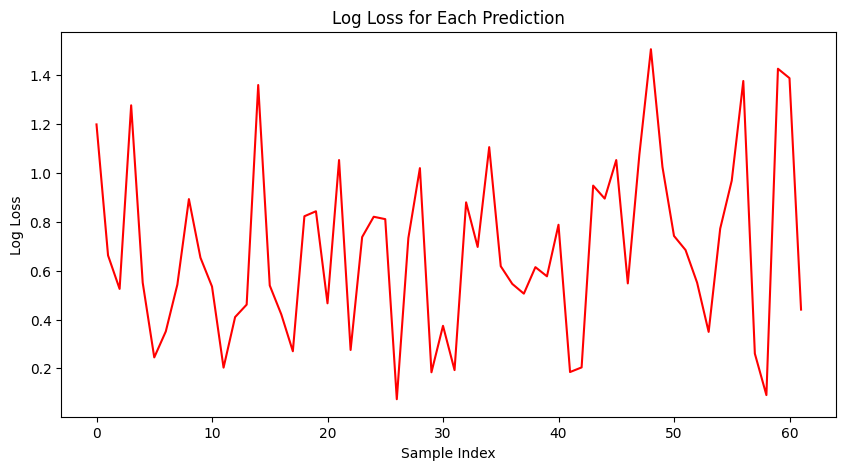

In [ ]:
# Adjust parameters for regularization
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Control tree depth
    min_samples_split=5,  # Minimum samples required to split a node
    min_samples_leaf=4,  # Minimum samples required at a leaf node
    max_features='sqrt',  # Use sqrt(features) at each split
    random_state=42,
)

# Train the model using the resampled training data with new parameters
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, rf_classifier)

### 4. Hyperparameter Tuning with Random Search
The perform_random_search function which was previously used in the feature-level analysis to perform hyperparameter tuning using Randomized Search was also used on the patient-level.

In [ ]:
# Step 1: Define the parameter grid for RandomForest
param_dist_rf = {
    'n_estimators': randint(100, 500),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of each tree
    'min_samples_split': randint(2, 10),  # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 5),  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider at each split
}

In [ ]:
# Step 2: Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Step 3: Perform Random Search for hyperparameter tuning
best_rf_model, best_rf_params, best_rf_score = perform_random_search(
    classifier=rf_classifier,
    param_distributions=param_dist_rf,
    X_train=X_train_smote,
    y_train=y_train_smote
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 153}
Best Cross-Validation Score: 0.7118414918414918


Accuracy: 0.5645161290322581
ROC-AUC: 0.5113636363636364
              precision    recall  f1-score   support

           0       0.29      0.33      0.31        18
           1       0.71      0.66      0.68        44

    accuracy                           0.56        62
   macro avg       0.50      0.50      0.50        62
weighted avg       0.58      0.56      0.57        62



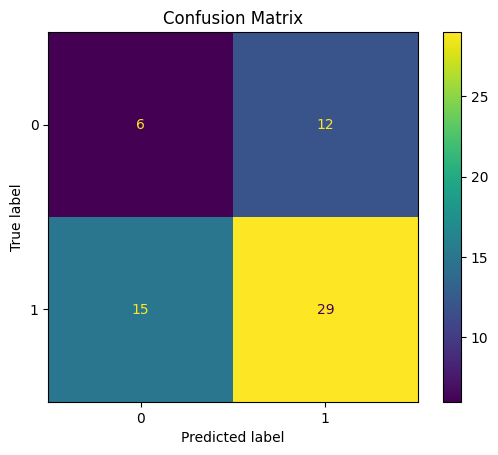

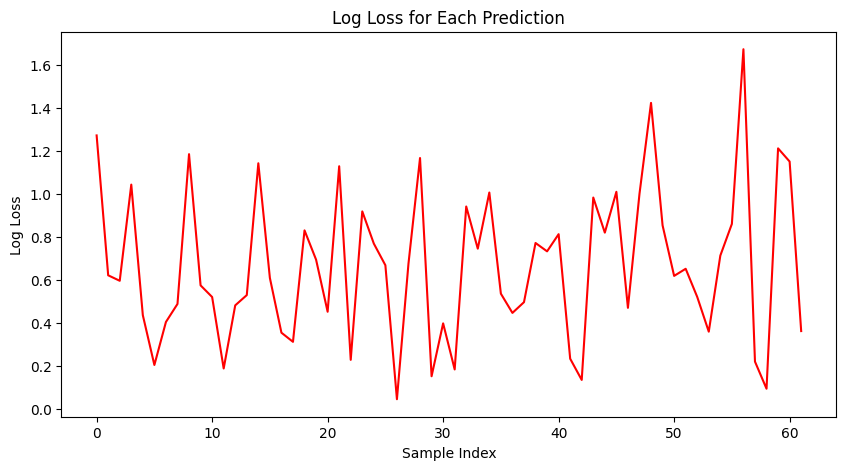

In [ ]:
# Step 4: Train and Evaluate the Best Model
trained_rf = train_model(X_train_smote, X_test, y_train_smote, y_test, best_rf_model)

## XGBoost Model Classification for the Lung Segmented Data at Patient Level

This section provides a detailed analysis of the XGBoost model applied to lung-segmented data at the patient level.

### Baseline XGB Mdodel

C:\Users\752306\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6129032258064516
ROC-AUC: 0.5580808080808081
              precision    recall  f1-score   support

           0       0.33      0.33      0.33        18
           1       0.73      0.73      0.73        44

    accuracy                           0.61        62
   macro avg       0.53      0.53      0.53        62
weighted avg       0.61      0.61      0.61        62



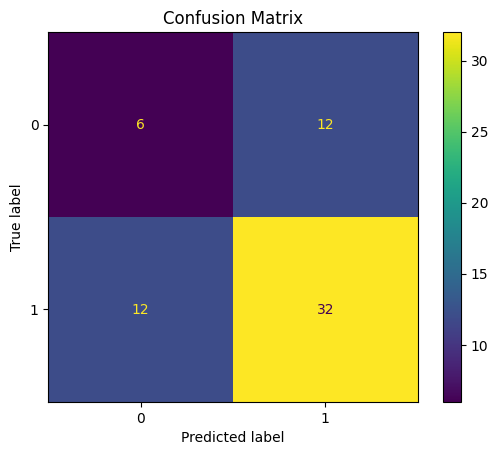

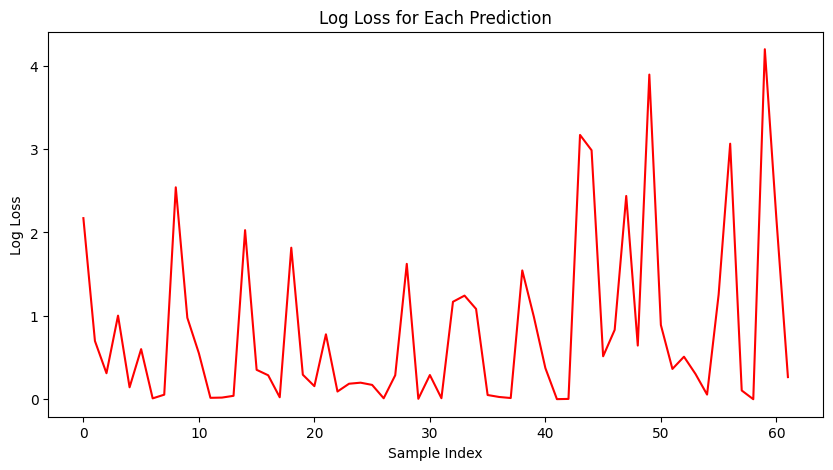

In [ ]:
# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model using the XGBoost classifier
trained_xgb = train_model(X_train_smote, X_test, y_train_smote, y_test, xgb_classifier)

### 2. Hyperparameter Tuning with Random Search

To optimize the performance of the XGBoost model, Random Search for hyperparameter tuning was used. The `perform_random_search` function explores a defined search space of hyperparameters and identifies the best combination that maximizes the model's performance.

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [3, 5, 7, 9, 11],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of features used per tree
    'min_child_weight': [1, 3, 5, 7],  # Minimum sum of weights for child nodes
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1],  # L2 regularization
}

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Use the perform_random_search function
best_xgb_model, best_xgb_params, best_xgb_score = perform_random_search(
    classifier=xgb_classifier,
    param_distributions=param_grid_xgb,
    X_train=X_train_smote,  # training features after SMOTE
    y_train=y_train_smote,  # training labels after SMOTE
    cv=5,
    n_iter=50,  # Number of iterations
    scoring='accuracy'  # Scoring metric
)

# Output the best model details
print("Best XGBoost Model:", best_xgb_model)
print("Best Parameters for XGBoost:", best_xgb_params)
print("Best Score for XGBoost:", best_xgb_score)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\752306\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:00:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}
Best Cross-Validation Score: 0.6871794871794872
Best XGBoost Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42

C:\Users\752306\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:00:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6129032258064516
ROC-AUC: 0.49116161616161613
              precision    recall  f1-score   support

           0       0.33      0.33      0.33        18
           1       0.73      0.73      0.73        44

    accuracy                           0.61        62
   macro avg       0.53      0.53      0.53        62
weighted avg       0.61      0.61      0.61        62



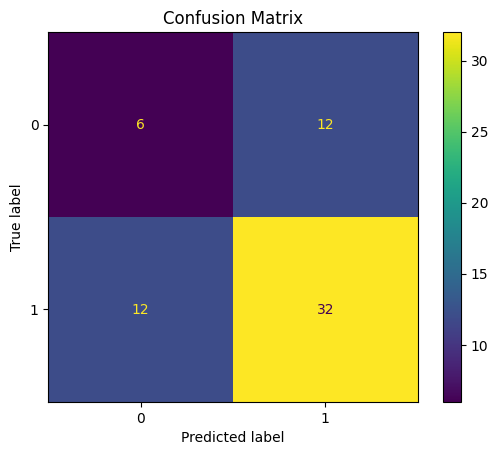

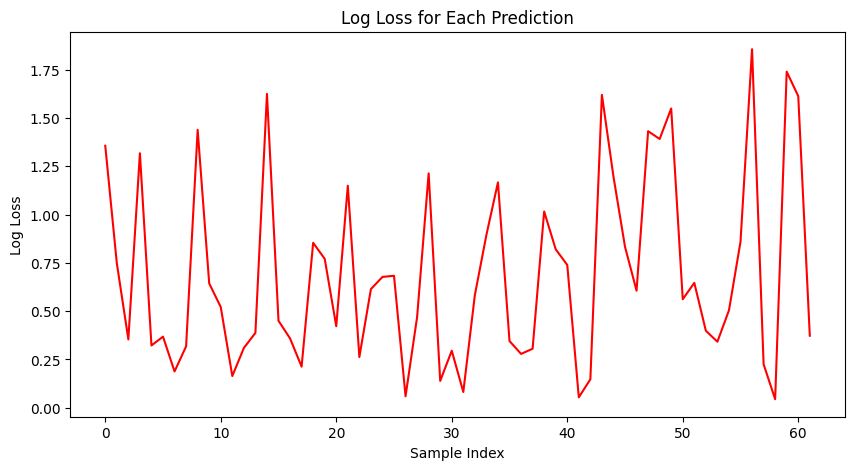

In [ ]:
# For XGBoost, use the best model obtained from random search
trained_xgb = train_model(X_train_smote, X_test, y_train_smote, y_test, best_xgb_model)

# Full-Body Analysis at Patient Level - Deep Learning

This section demonstrates the application of pre-built Fully Connected Neural Network (FCNN) models to full-body patient-level data. The process begins with utilizing the baseline FCNN model for binary classification, followed by applying two pre-tuned FCNN models to assess model performance across different configurations. The models are evaluated using metrics such as accuracy, ROC-AUC, and confusion matrix, with visualizations for training loss and validation loss

### 1: Baseline FCNN Model Initialization and Training

The baseline Fully Connected Neural Network (FCNN) is trained on the standardized full body training data. As earlier described, the model has two hidden layers and uses ReLU activation. The Adam optimizer is used to train the model, and the training performance is evaluated using the test set.


In [ ]:
# Load and Prepare the Data
combined_df = pd.read_csv('New_Full_Patient_Level_radiomics_features_labels.csv')  # Load the combined features and labels from a CSV file

# Separate the features and labels from the re-loaded combined DataFrame
features_df = combined_df.drop('label', axis=1)  # Drop the 'label' column to create a DataFrame with only feature columns
labels = combined_df['label']  # Extract the 'label' column as the target labels array

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_df, labels, test_size=0.2, random_state=42
)  # Use 20% of the data for testing, and set a random state for reproducibility
# Standardize the data

# Standardize the Data
scaler = StandardScaler()  # Initialize a StandardScaler to standardize the features

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)  # Scale the training features

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)  # Scale the testing features using the scaler fitted on the training data

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9162 - loss: 0.4805 - val_accuracy: 0.9839 - val_loss: 0.1761
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9747 - loss: 0.2271 - val_accuracy: 0.9839 - val_loss: 0.0894
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.1498 - val_accuracy: 0.9839 - val_loss: 0.0707
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9898 - loss: 0.0707 - val_accuracy: 0.9839 - val_loss: 0.0693
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9832 - loss: 0.0659 - val_accuracy: 0.9839 - val_loss: 0.0715
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0416 - val_accuracy: 0.9839 - val_loss: 0.0772
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0425 - val_accuracy: 0.9839 - val_loss: 0.0867
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - loss: 0.0330 - val_accuracy: 0.9839 - val_loss

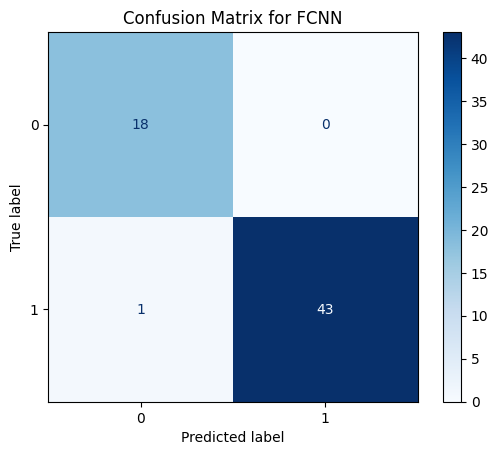

ROC-AUC Score: 0.9949494949494949


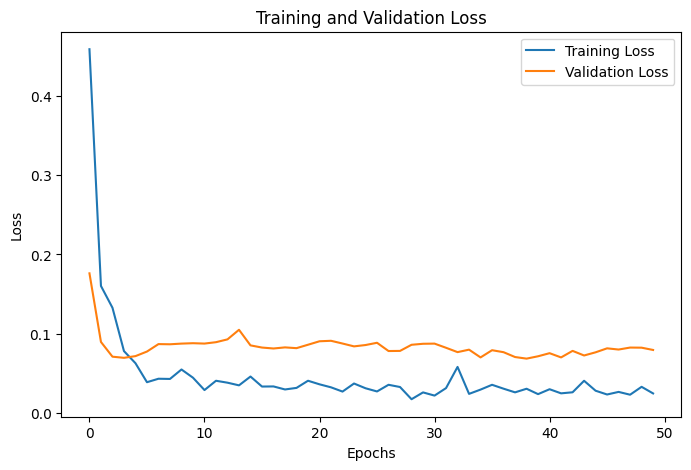

In [ ]:
# Train and evaluate the baseline FCNN model on the full body data at patient level
fcnn_model, fcnn_history = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],  # Number of input features
    hidden_layers=[128, 64],  # Two hidden layers
    activation='relu',  # ReLU activation function for hidden layers
    dropout_rates=[0.3, 0.2],  # Dropout rates for regularization
    optimizer='adam',  # Adam optimizer
    epochs=50,  # Train for 50 epochs
    batch_size=16  # Batch size of 16
)

### 1st Hyper Parameter Tuning

As earlier described the baseline FCNN model is modified to include more hidden layers with adjusted dropout rates. The optimizer is switched to Stochastic Gradient Descent (SGD), and the number of epochs is increased to improve convergence and performance.

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5017 - loss: 0.6590 - val_accuracy: 0.9839 - val_loss: 0.5181
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8709 - loss: 0.5466 - val_accuracy: 0.9839 - val_loss: 0.4366
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9146 - loss: 0.4521 - val_accuracy: 0.9839 - val_loss: 0.3677
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9631 - loss: 0.3918 - val_accuracy: 0.9839 - val_loss: 0.3121
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9787 - loss: 0.3675 - val_accuracy: 0.9839 - val_loss: 0.2642
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.2969 - val_accuracy: 0.9839 - val_loss: 0.2282
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9744 - loss: 0.3133 - val_accuracy: 0.9839 - val_loss: 0.1953
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9677 - loss: 0.2587 - val_accuracy: 0.9839 - v

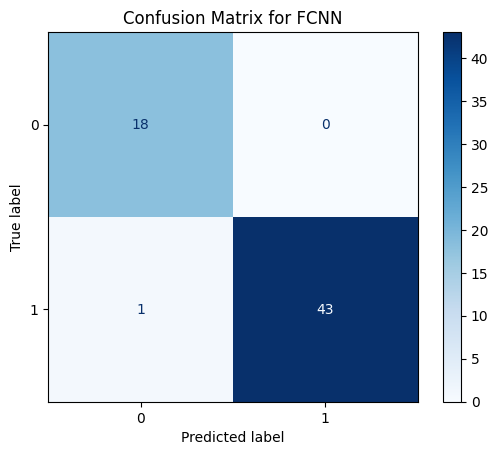

ROC-AUC Score: 0.9886363636363636


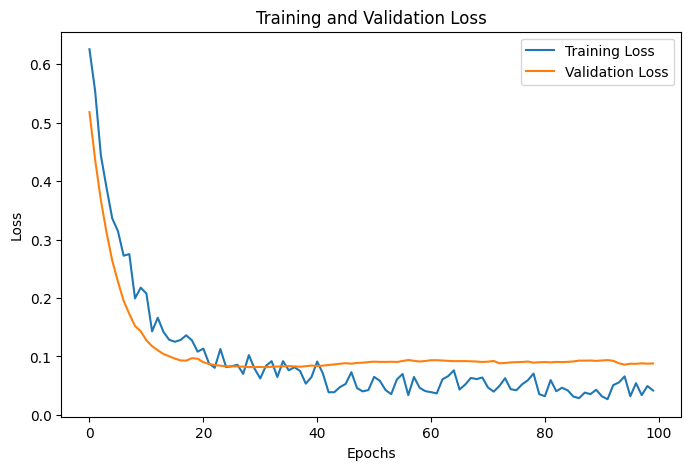

In [ ]:
fcnn_model_1, fcnn_history_1 = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],
    hidden_layers=[64, 32, 16],  # Adjusted hidden layers to 3 layers with fewer neurons
    activation='relu',
    dropout_rates=[0.2, 0.2, 0.1],  # Changed dropout rates
    optimizer='sgd',  # Using SGD instead of Adam
    epochs=100,  # Increased epochs for better convergence
    batch_size=16  # Smaller batch size
)

### 2nd Hyper Parameter Tuning

Further tuning is performed by using larger hidden layers, tanh activation functions, and the RMSprop optimizer. This configuration is designed to test the effect of different activation functions and optimizers on model performance.

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8963 - loss: 0.1965 - val_accuracy: 0.9839 - val_loss: 0.0961
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9763 - loss: 0.1253 - val_accuracy: 0.9839 - val_loss: 0.1164
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0511 - val_accuracy: 0.9839 - val_loss: 0.0987
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0448 - val_accuracy: 0.9839 - val_loss: 0.0977
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0601 - val_accuracy: 0.9839 - val_loss: 0.1109
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0539 - val_accuracy: 0.9839 - val_loss: 0.1203
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0141 - val_accuracy: 0.9839 - val_loss: 0.1097
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0683 - val_accuracy: 0.9839 - val_loss:

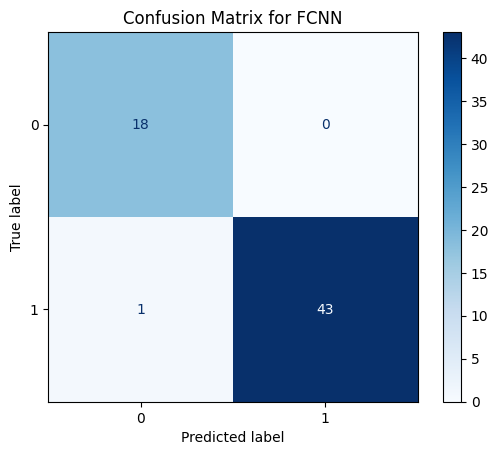

ROC-AUC Score: 0.9886363636363636


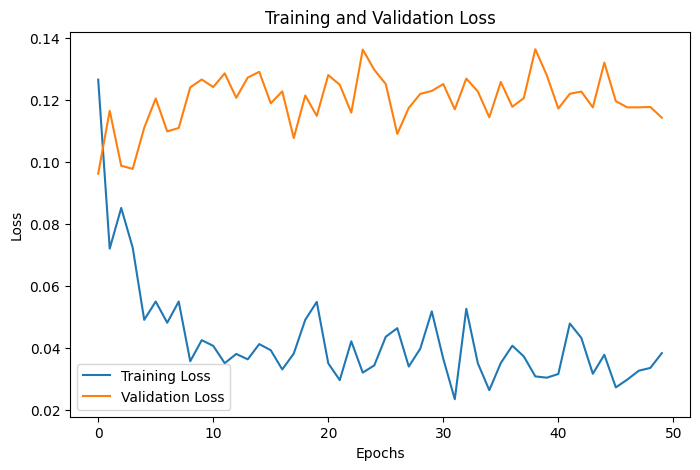

In [ ]:
# Second hyperparameter tuning: Fewer but larger hidden layers, different activation, and optimizer
fcnn_model_2, fcnn_history_2 = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],  # Number of input features
    hidden_layers=[256, 128],  # Two hidden layers with more neurons
    activation='tanh',  # Use tanh activation function
    dropout_rates=[0.4, 0.3],  # Increased dropout rates for regularization
    optimizer='rmsprop',  # Use RMSprop optimizer
    epochs=50,  # Train for 50 epochs
    batch_size=8  # Smaller batch size for better generalization
)

# Lung-Segmented Analysis at Patient Level - Deep Learning

This section demonstrates the application of the pre-built Fully Connected Neural Network (FCNN) models to lung-*segmented* patient-level data. The process begins with utilizing the baseline FCNN model for binary classification, followed by applying two pre-tuned FCNN models to assess model performance across different configurations. The models are evaluated using metrics such as accuracy, ROC-AUC, and confusion matrix, with visualizations for training loss and validation loss

### 1: Baseline FCNN Model Initialization and Training

The baseline Fully Connected Neural Network (FCNN) is trained on the standardized lung-segmented training data. As earlier described, the model has two hidden layers and uses ReLU activation. The Adam optimizer is used to train the model, and the training performance is evaluated using the test set.

In [ ]:
# Load and Prepare the Data
combined_df = pd.read_csv('New Segmented_Patient_Level_radiomics_features_labels.csv')  # Load the combined features and labels from a CSV file

# Separate the features and labels from the re-loaded combined DataFrame
features_df = combined_df.drop('label', axis=1)  # Drop the 'label' column to create a DataFrame with only feature columns
labels = combined_df['label']  # Extract the 'label' column as the target labels array

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4581 - loss: 0.7984 - val_accuracy: 0.6935 - val_loss: 0.6503
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6195 - loss: 0.6847 - val_accuracy: 0.7097 - val_loss: 0.6252
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6852 - loss: 0.6029 - val_accuracy: 0.7097 - val_loss: 0.6141
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6411 - loss: 0.6573 - val_accuracy: 0.7258 - val_loss: 0.6011
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6266 - loss: 0.6450 - val_accuracy: 0.7097 - val_loss: 0.5952
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6780 - loss: 0.6090 - val_accuracy: 0.6935 - val_loss: 0.5879
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6549 - loss: 0.6260 - val_accuracy: 0.7097 - val_loss: 0.5881
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6040 - loss: 0.6417 - val_accuracy: 0.6935 - val_loss:

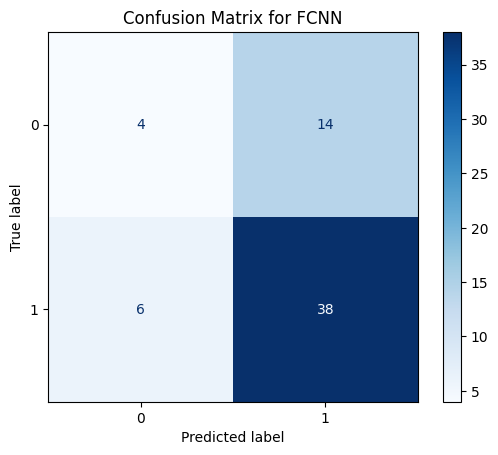

ROC-AUC Score: 0.42045454545454547


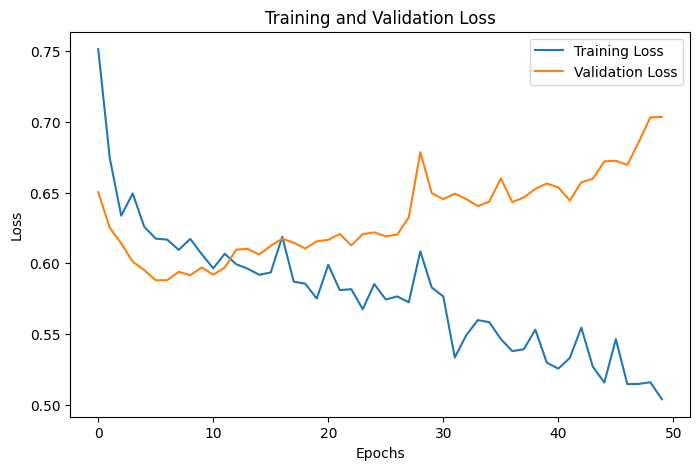

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

fcnn_model, fcnn_history = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],
    hidden_layers=[128, 64],  # Two hidden layers
    activation='relu',
    dropout_rates=[0.3, 0.2],
    optimizer='adam',
    epochs=50,
    batch_size=16
)

### 1st Hyper Parameter Tuning

As earlier described the baseline FCNN model is modified to include more hidden layers with adjusted dropout rates. The optimizer is switched to Stochastic Gradient Descent (SGD), and the number of epochs is increased to improve convergence and performance.

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6750 - loss: 0.6543 - val_accuracy: 0.7419 - val_loss: 0.6654
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5925 - loss: 0.7037 - val_accuracy: 0.7419 - val_loss: 0.6642
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6197 - loss: 0.6879 - val_accuracy: 0.7419 - val_loss: 0.6620
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7069 - loss: 0.6397 - val_accuracy: 0.7419 - val_loss: 0.6593
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6578 - loss: 0.6793 - val_accuracy: 0.7419 - val_loss: 0.6590
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6297 - loss: 0.6629 - val_accuracy: 0.7419 - val_loss: 0.6559
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6667 - loss: 0.6442 - val_accuracy: 0.7581 - val_loss: 0.6521
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6725 - loss: 0.6546 - val_accuracy: 0.7581 - v

C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


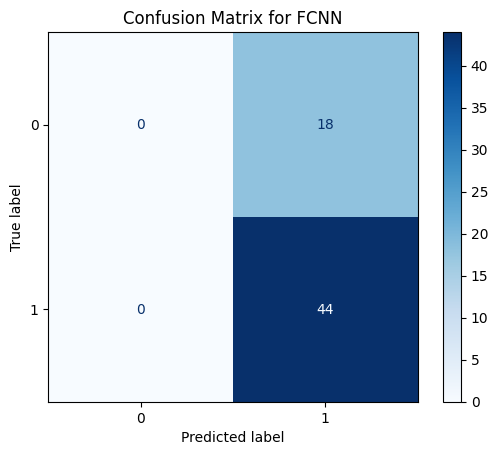

ROC-AUC Score: 0.518939393939394


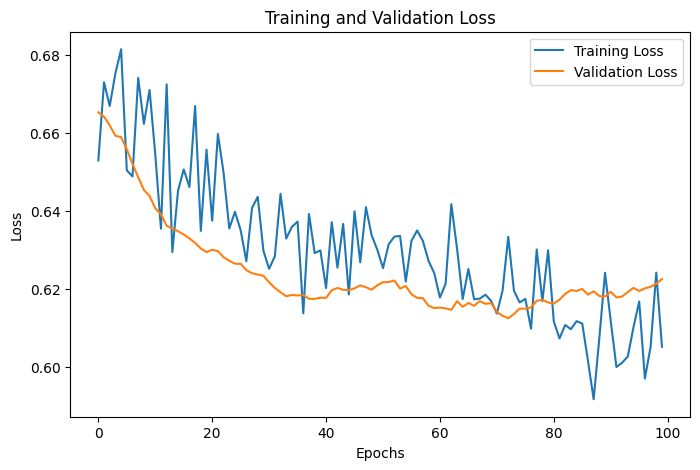

In [ ]:
# Tune hyperparameters dynamically by calling the function with different settings
fcnn_model_1, fcnn_history_1 = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],
    hidden_layers=[64, 32, 16],  # Adjusted hidden layers to 3 layers with fewer neurons
    activation='relu',
    dropout_rates=[0.2, 0.2, 0.1],  # Changed dropout rates
    optimizer='sgd',  # Using SGD instead of Adam
    epochs=100,  # Increased epochs for better convergence
    batch_size=16  # Smaller batch size
)

### 2nd Hyper Parameter Tuning

Further tuning is performed by using larger hidden layers, tanh activation functions, and the RMSprop optimizer. This configuration is designed to test the effect of different activation functions and optimizers on model performance.

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5641 - loss: 0.7773 - val_accuracy: 0.6129 - val_loss: 0.6579
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6041 - loss: 0.7587 - val_accuracy: 0.6452 - val_loss: 0.6299
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5741 - loss: 0.7331 - val_accuracy: 0.6290 - val_loss: 0.6400
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6314 - loss: 0.6222 - val_accuracy: 0.6613 - val_loss: 0.6448
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6680 - loss: 0.6643 - val_accuracy: 0.6774 - val_loss: 0.6372
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6491 - loss: 0.6516 - val_accuracy: 0.7258 - val_loss: 0.6539
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6855 - loss: 0.6199 - val_accuracy: 0.6290 - val_loss: 0.6245
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6340 - loss: 0.6453 - val_accuracy: 0.6452 - val_loss:

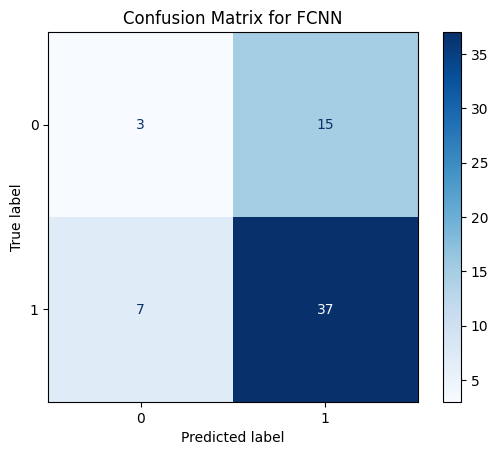

ROC-AUC Score: 0.6452020202020203


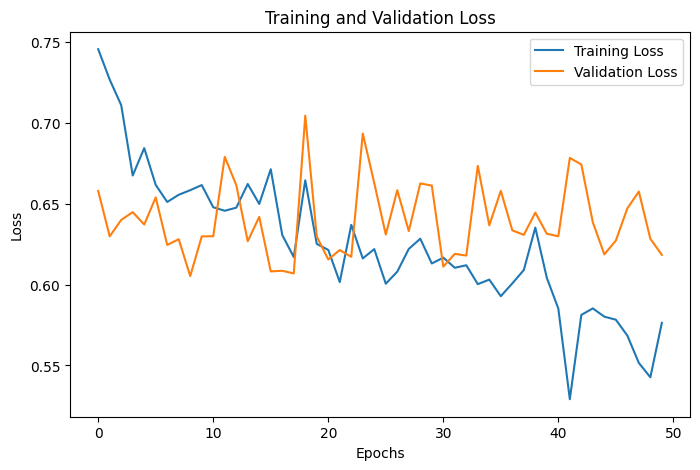

In [ ]:
fcnn_model_2, fcnn_history_2 = build_and_train_fcnn(
    X_train_scaled, X_test_scaled, y_train, y_test,
    input_dim=X_train_scaled.shape[1],
    hidden_layers=[256, 128],  # Fewer but larger hidden layers
    activation='tanh',  # Use tanh activation function
    dropout_rates=[0.4, 0.3],  # Higher dropout rates
    optimizer='rmsprop',  # Use RMSprop optimizer
    epochs=50,  # Default epochs
    batch_size=8  # Smaller batch size for better generalization
)